In [ ]:
!pip install umap-learn --quiet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import tqdm
import umap
import seaborn as sns

In [ ]:
%%capture
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.1307,), (0.3081,))  # Mean and std for MNIST
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=96, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=96, shuffle=False)

In [ ]:
class VAE(torch.nn.Module):
  def __init__(self, config):
    super(VAE, self).__init__()
    kernel_sizes = config['kernel_sizes']
    strides = config['strides']
    paddings = config['paddings']
    features = config['conv_features']
    linear_features = config['linear_features']

    enc_layers = []
    dec_layers = []
    l = len(features)
    for i in range(l-1):
      enc_layers.append(nn.Conv2d(kernel_size=kernel_sizes[i], stride=strides[i], padding=paddings[i], in_channels=features[i], out_channels=features[i+1]))
      if i == 0:
        dec_layers.append(nn.ConvTranspose2d(kernel_size=kernel_sizes[l-i-2], stride=strides[l-i-2], padding=paddings[l-i-2], in_channels=features[l-i-1], out_channels=features[l-i-2]))
      else:
        dec_layers.append(nn.ConvTranspose2d(kernel_size=kernel_sizes[l-i-2], stride=strides[l-i-2], padding=paddings[l-i-2], in_channels=features[l-i-1], out_channels=features[l-i-2]))
        enc_layers.append(nn.BatchNorm2d(features[i+1]))
      enc_layers.append(nn.LeakyReLU())
      if i != l-2:
        dec_layers.append(nn.BatchNorm2d(features[l-i-2]))
        dec_layers.append(nn.LeakyReLU())
      else:
        dec_layers.append(nn.Sigmoid())

    lin_encoder = [torch.nn.Linear(4 * 4 * features[-1], linear_features[0]), nn.LeakyReLU(), torch.nn.Linear(linear_features[0], linear_features[1] * 2)]
    lin_decoder = [torch.nn.Linear(linear_features[1], linear_features[0]), nn.LeakyReLU(), torch.nn.Linear(linear_features[0], 4 * 4 * features[-1])]

    self.encoder = torch.nn.Sequential(
        *enc_layers
    )
    self.lin_encode = torch.nn.Sequential(
        *lin_encoder
    )
    self.decoder = torch.nn.Sequential(
        *dec_layers
    )
    self.lin_decode = torch.nn.Sequential(
        *lin_decoder
    )

  def decode(self, x):
    x = self.lin_decode(x)
    x = x.view(x.size(0), -1, 4, 4)
    x = self.decoder(x)
    return x

  def forward(self, x):
    latent = self.encoder(x)
    latent = latent.view(latent.size(0), -1)
    latent = self.lin_encode(latent)
    mu, log_var = torch.chunk(latent, 2, dim=1)
    sigma = torch.exp(0.5 * log_var)

    x_reparam = mu + torch.randn_like(sigma) * sigma
    #x_reparam = mu + torch.randn_like(sigma)
    x_recon = self.lin_decode(x_reparam)
    x_recon = x_recon.view(x_recon.size(0), -1, 4, 4)
    x_recon = self.decoder(x_recon)
    return x_recon, mu, log_var

In [ ]:
latent_shape = (10, 4, 4)
model = VAE({
    'kernel_sizes': [3, 4, 3, 4, 3],
    'strides': [1, 2, 1, 2, 2],
    'paddings': [1, 1, 1, 1, 1],
    'conv_features': [1, 32, 64, 64, 64, 32], # 28 -> 28 -> 14 -> 7 -> 4
    'linear_features' : [16, latent_shape[0]],
})
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=3e-5)
loss_fn = F.l1_loss
palette = sns.color_palette("tab10", 10)
reducer = umap.UMAP(n_components=2, random_state=69)

In [ ]:
print

AttributeError: 'VAE' object has no attribute 'info'

In [ ]:
def equalize(loss1, loss2):
  factor = loss1.cpu().detach().numpy() / loss2.cpu().detach().numpy()
  loss2 = loss2 * factor
  return loss1, loss2

Epoch 51/50: 100%|██████████| 625/625 [00:20<00:00, 31.09it/s, loss=0.0553]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 51 Average Loss: 0.0558


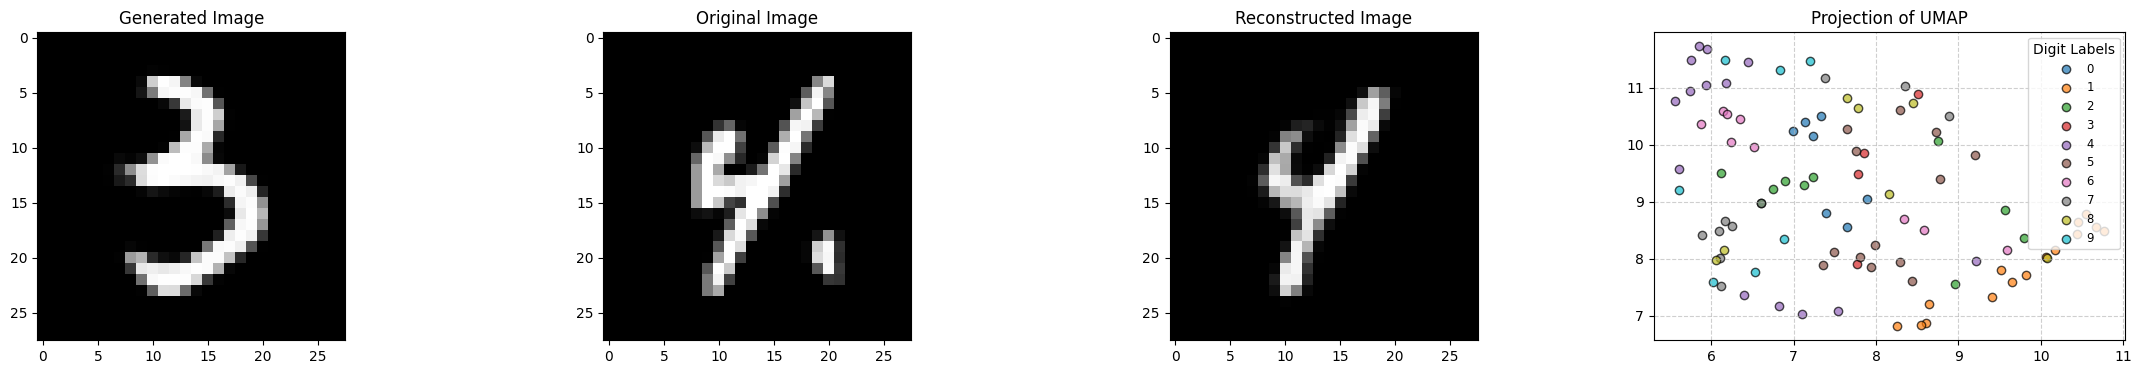

Epoch 52/50: 100%|██████████| 625/625 [00:15<00:00, 39.66it/s, loss=0.0549]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 52 Average Loss: 0.0556


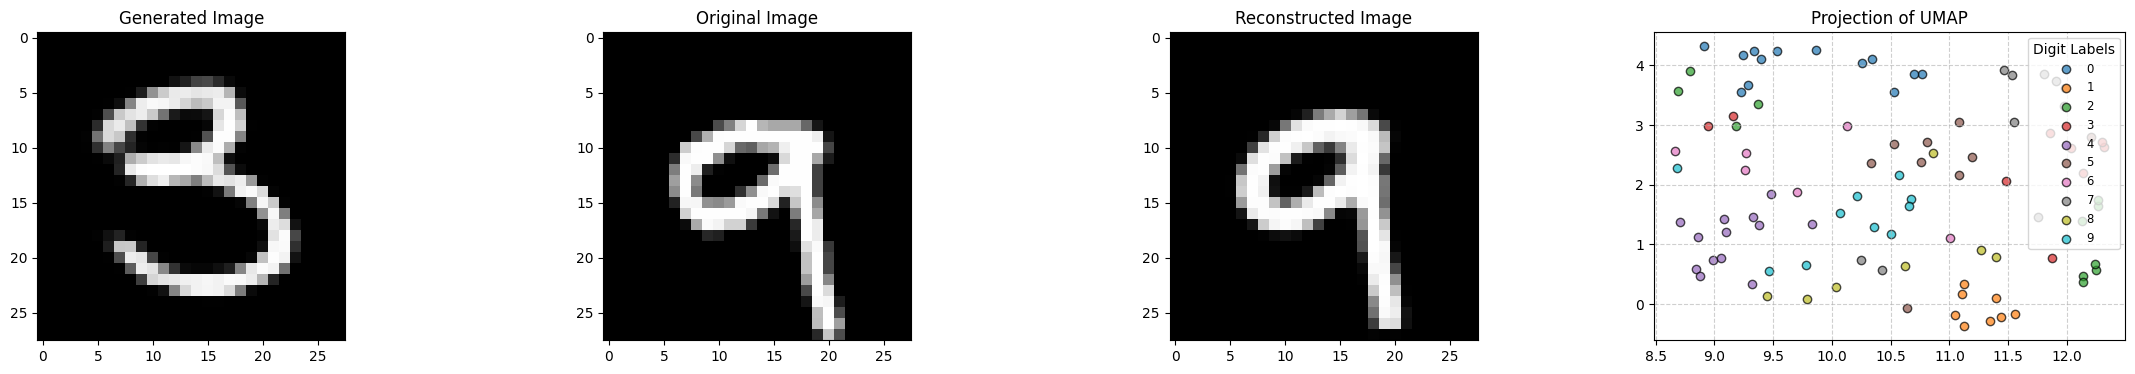

Epoch 53/50: 100%|██████████| 625/625 [00:16<00:00, 37.96it/s, loss=0.0553]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 53 Average Loss: 0.0555


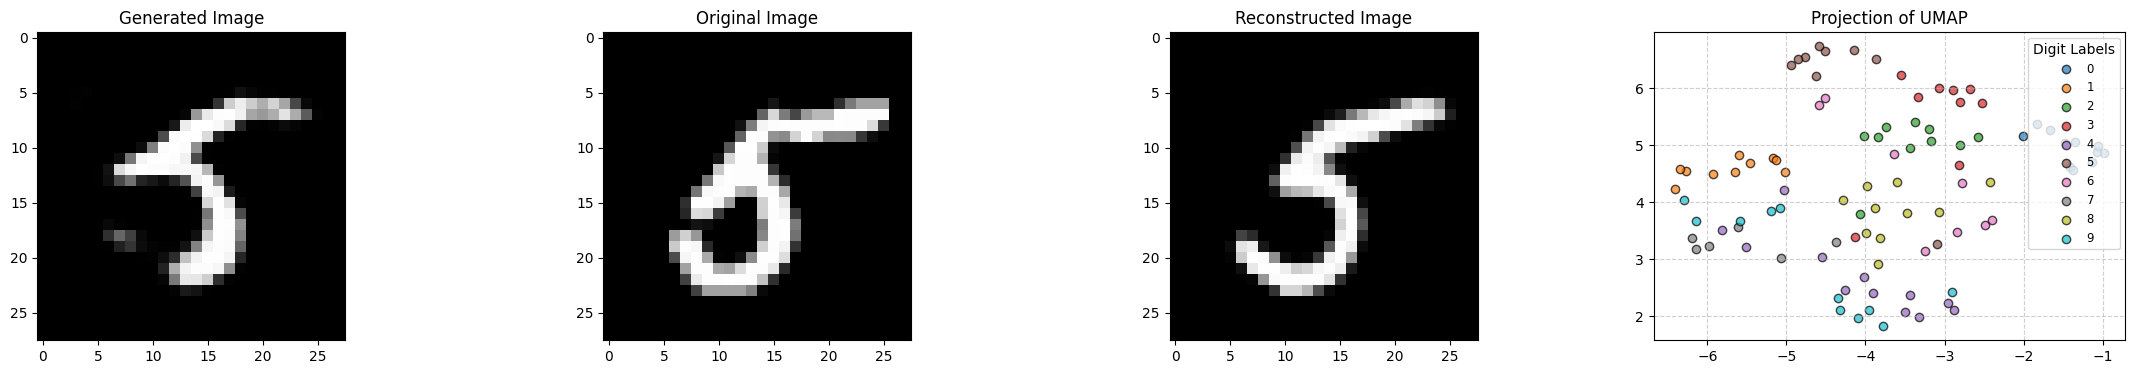

Epoch 54/50: 100%|██████████| 625/625 [00:16<00:00, 38.16it/s, loss=0.0534]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 54 Average Loss: 0.0554


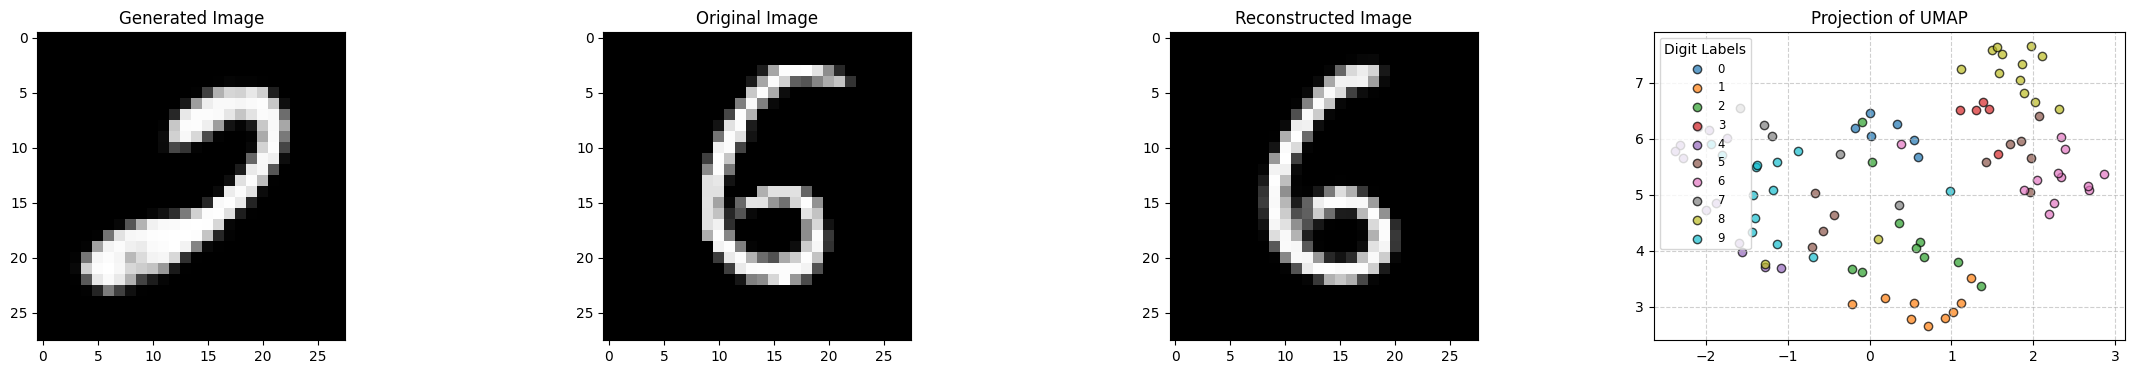

Epoch 55/50: 100%|██████████| 625/625 [00:17<00:00, 35.66it/s, loss=0.0551]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 55 Average Loss: 0.0553


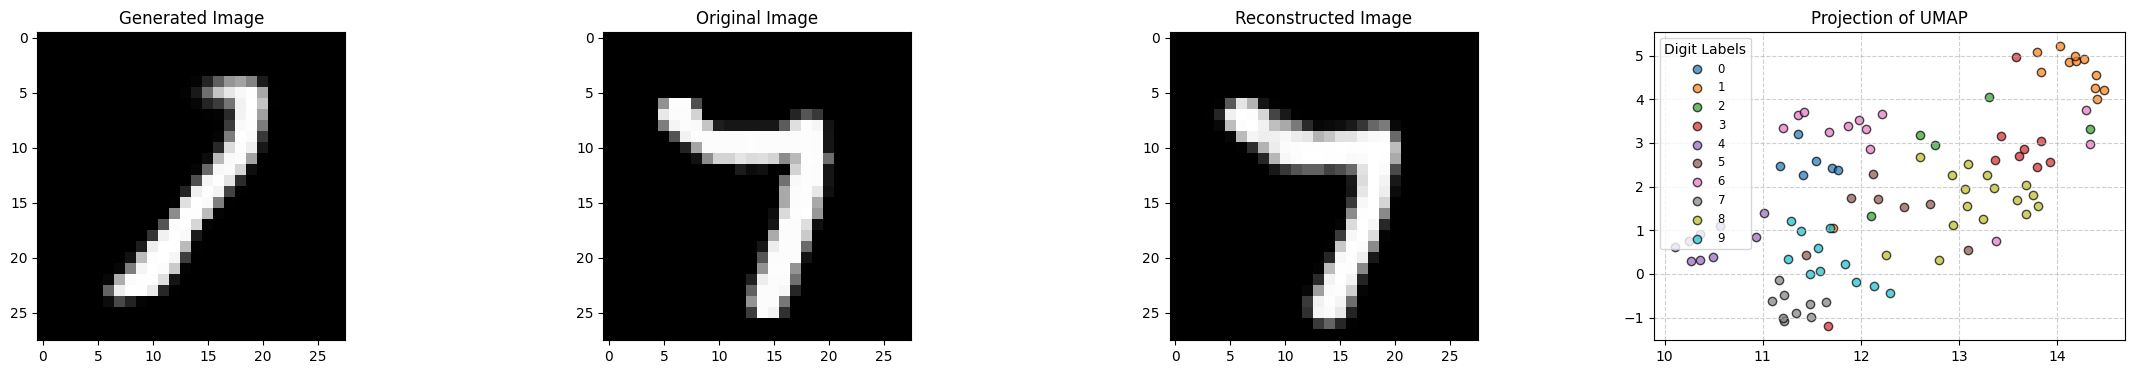

Epoch 56/50: 100%|██████████| 625/625 [00:17<00:00, 35.35it/s, loss=0.0551]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 56 Average Loss: 0.0552


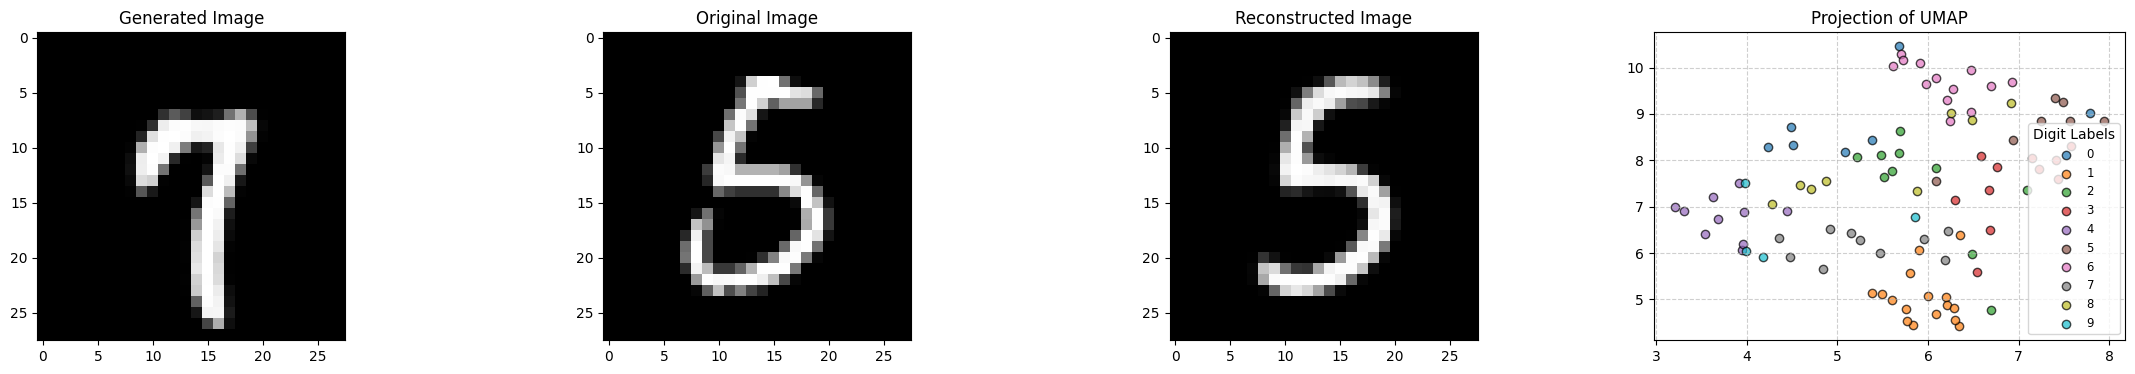

Epoch 57/50: 100%|██████████| 625/625 [00:17<00:00, 36.39it/s, loss=0.0583]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 57 Average Loss: 0.0551


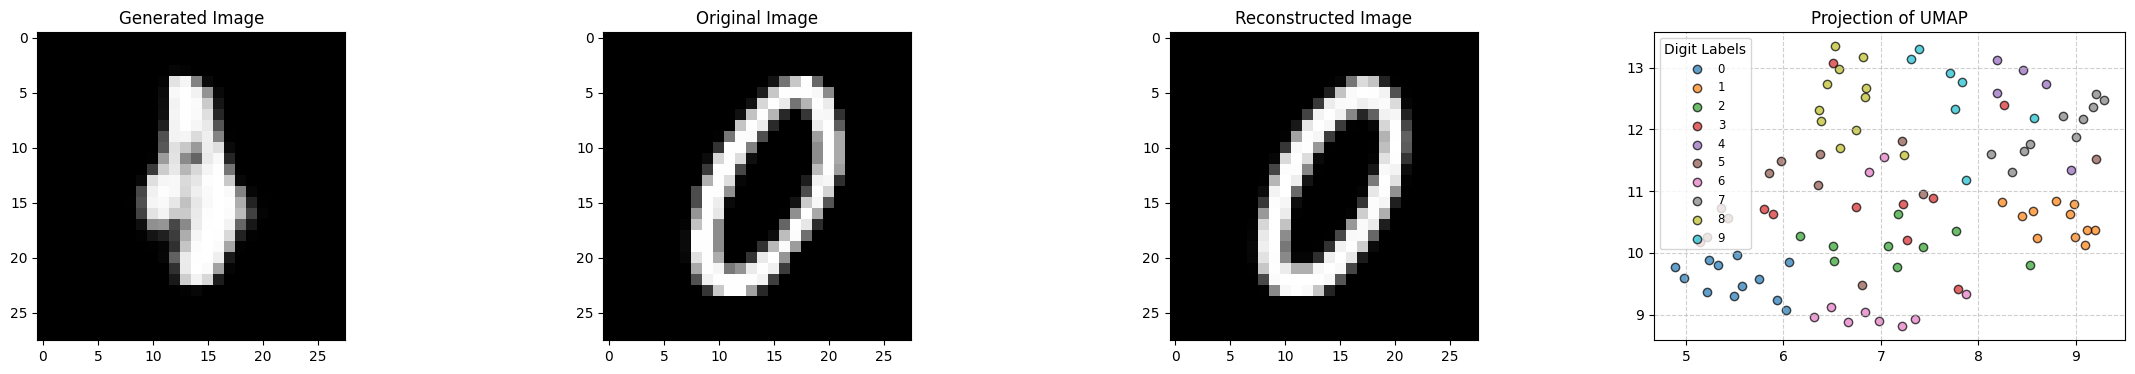

Epoch 58/50: 100%|██████████| 625/625 [00:17<00:00, 35.09it/s, loss=0.0558]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 58 Average Loss: 0.0551


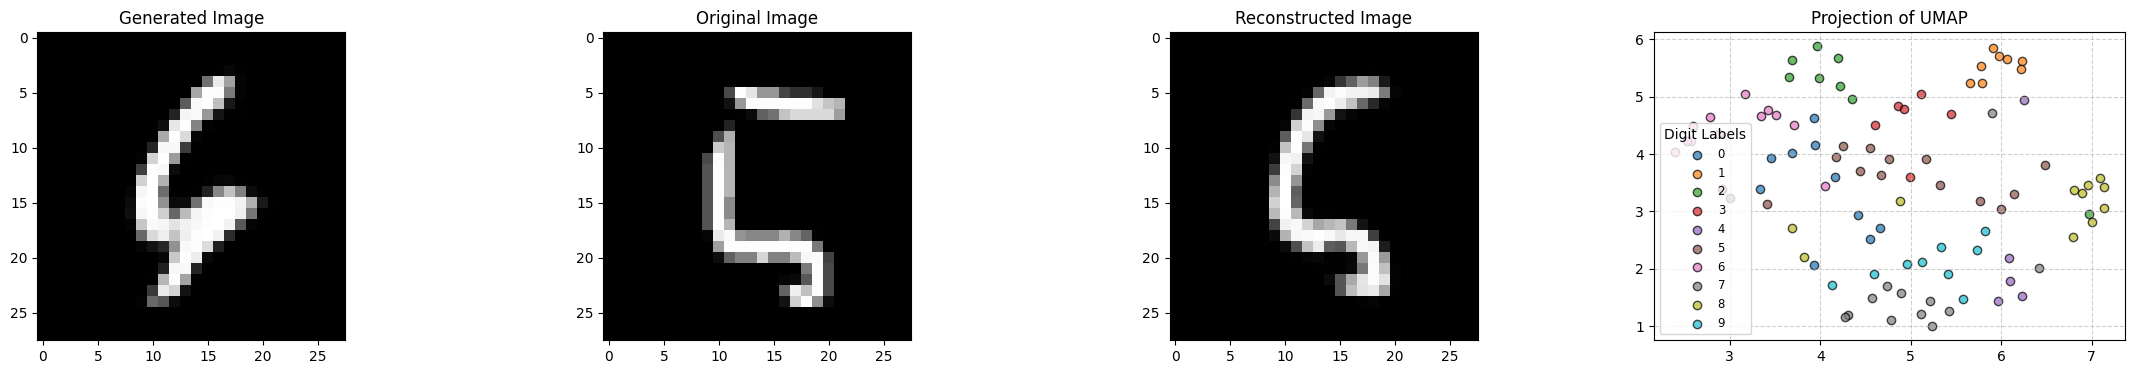

Epoch 59/50: 100%|██████████| 625/625 [00:17<00:00, 35.09it/s, loss=0.0571]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 59 Average Loss: 0.0549


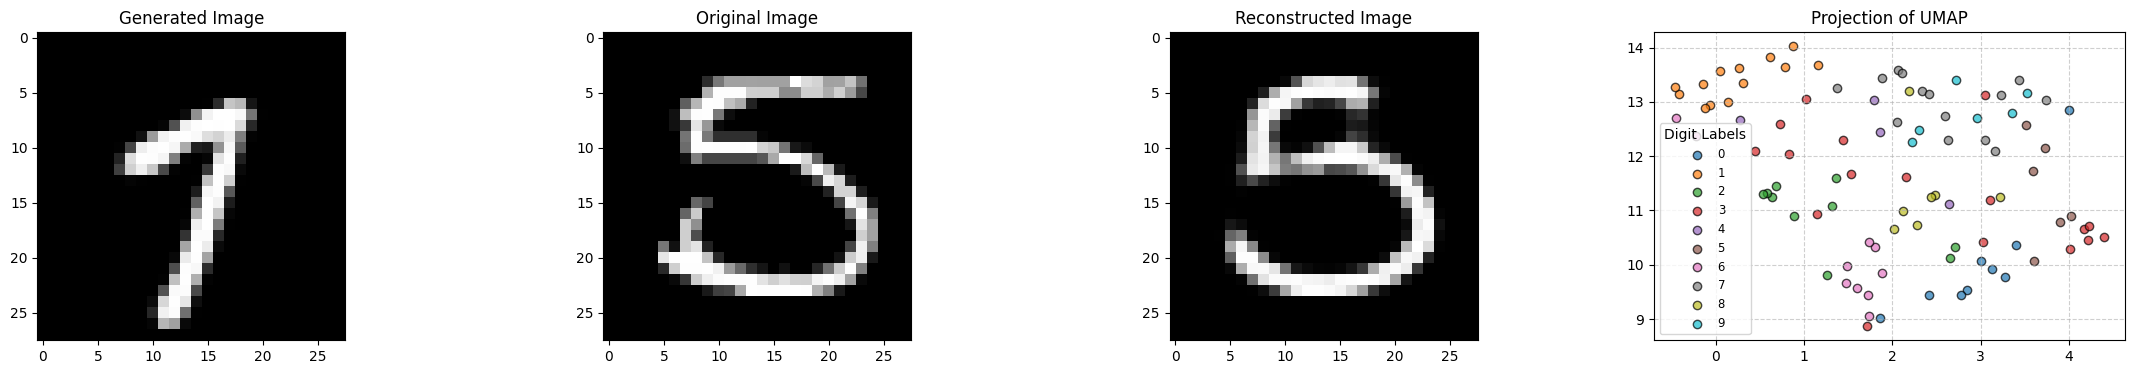

Epoch 60/50: 100%|██████████| 625/625 [00:19<00:00, 32.34it/s, loss=0.0572]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 60 Average Loss: 0.0549


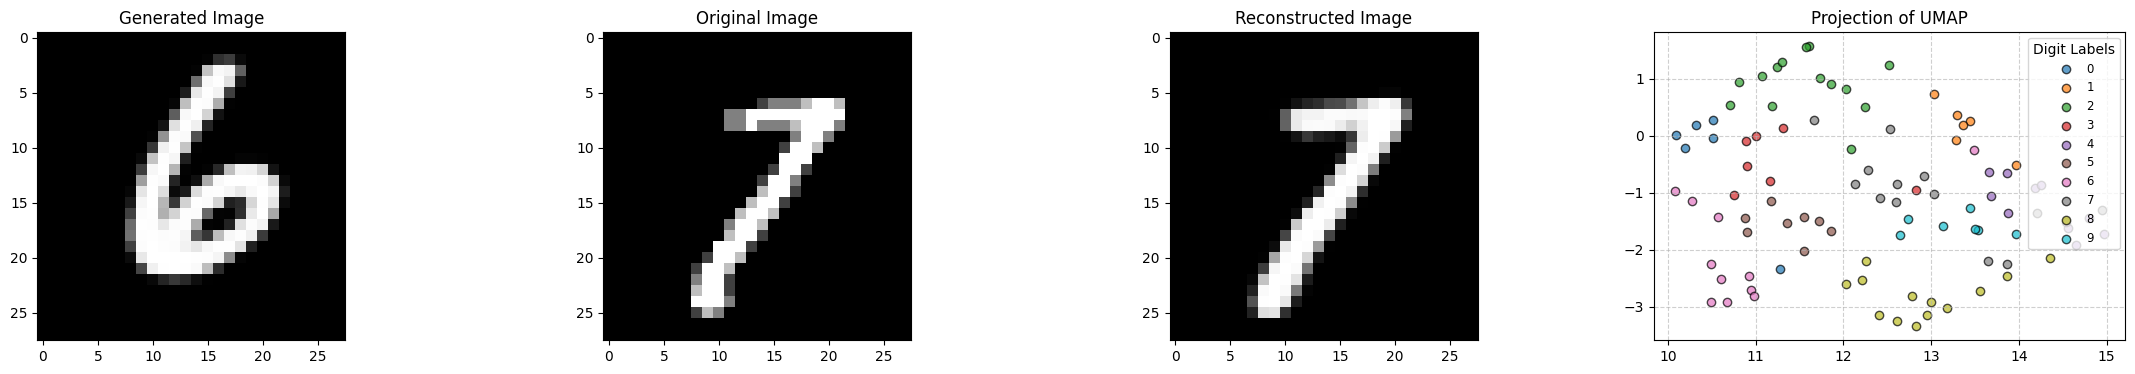

Epoch 61/50: 100%|██████████| 625/625 [00:18<00:00, 34.62it/s, loss=0.0524]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 61 Average Loss: 0.0548


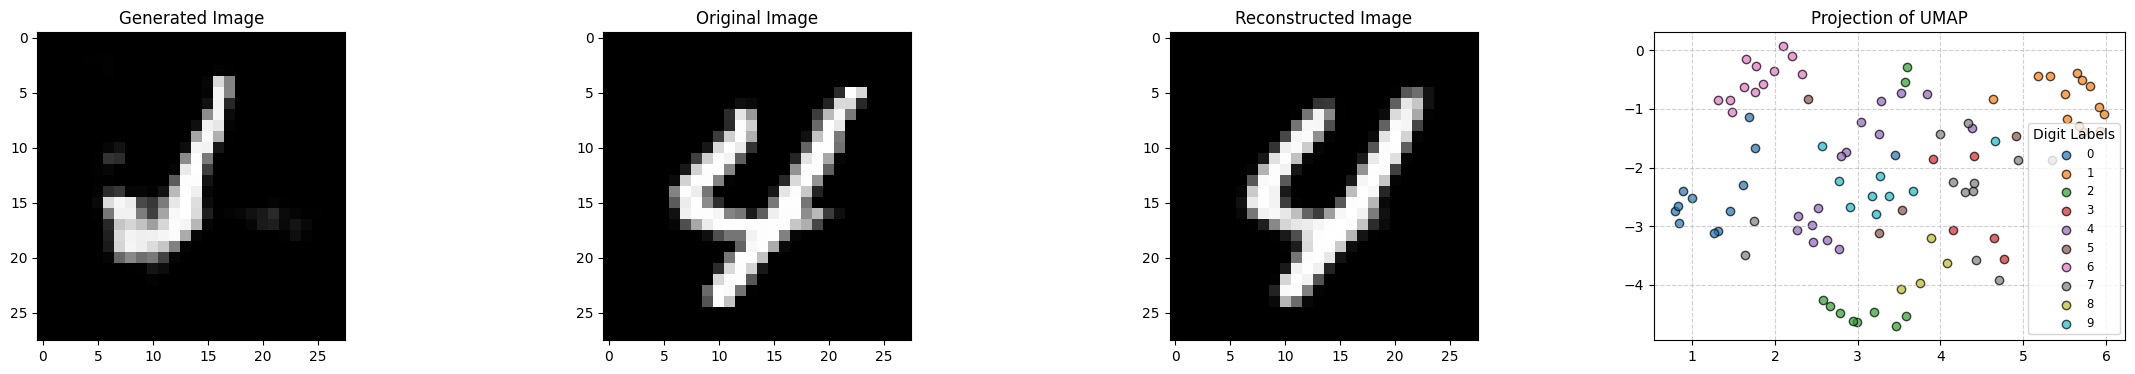

Epoch 62/50: 100%|██████████| 625/625 [00:18<00:00, 34.24it/s, loss=0.0582]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 62 Average Loss: 0.0548


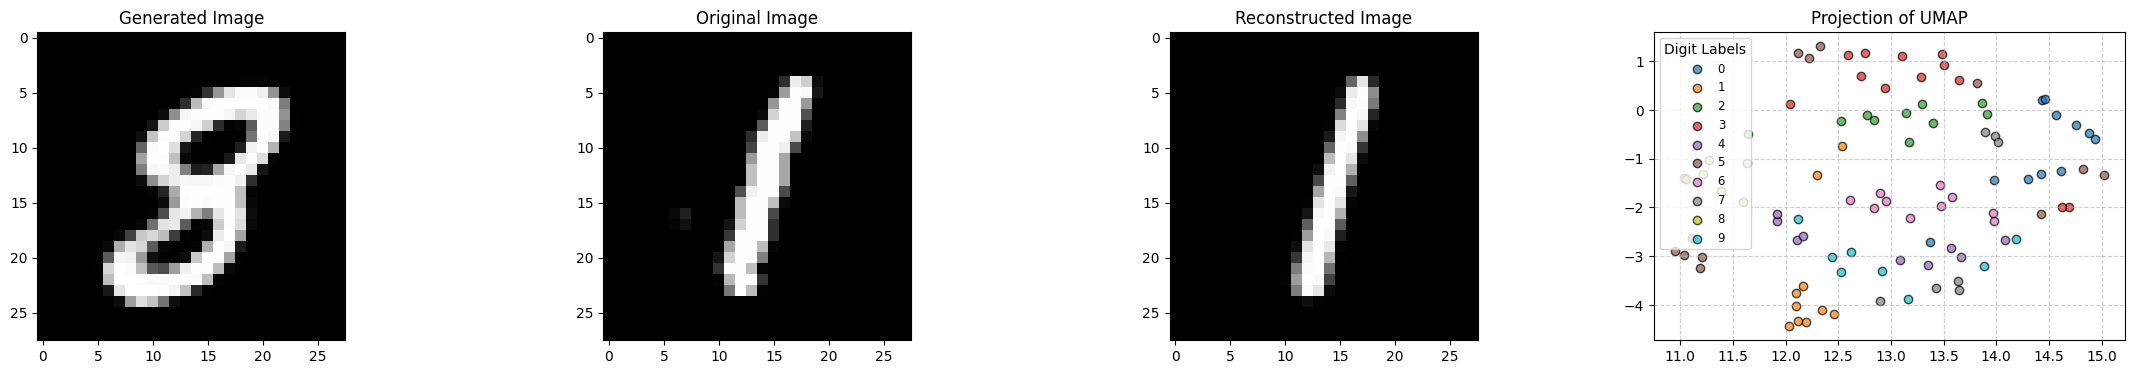

Epoch 63/50: 100%|██████████| 625/625 [00:18<00:00, 33.94it/s, loss=0.0556]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 63 Average Loss: 0.0547


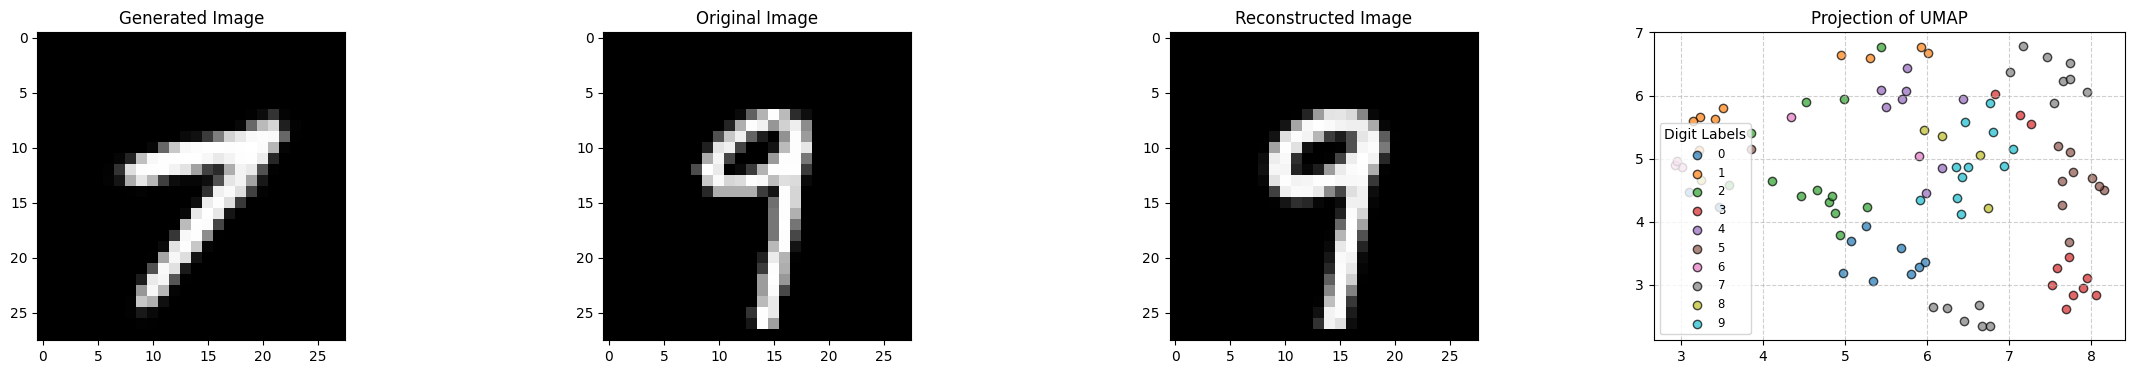

Epoch 64/50: 100%|██████████| 625/625 [00:18<00:00, 33.50it/s, loss=0.0536]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 64 Average Loss: 0.0546


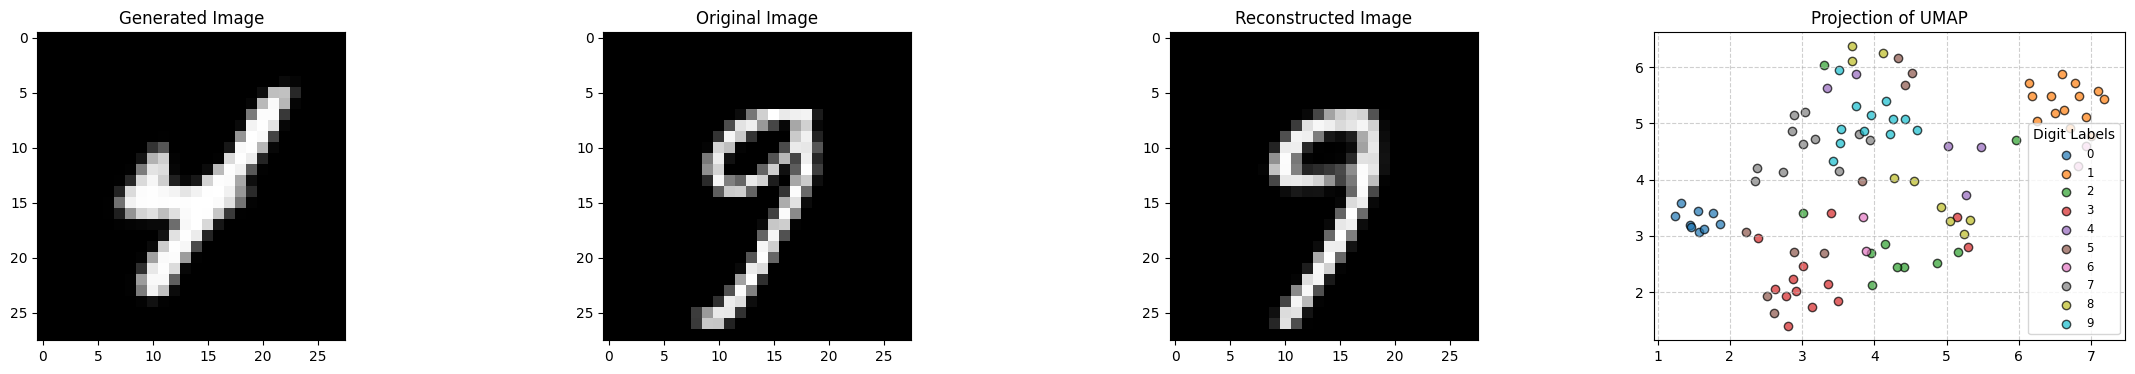

Epoch 65/50: 100%|██████████| 625/625 [00:18<00:00, 34.54it/s, loss=0.0566]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 65 Average Loss: 0.0546


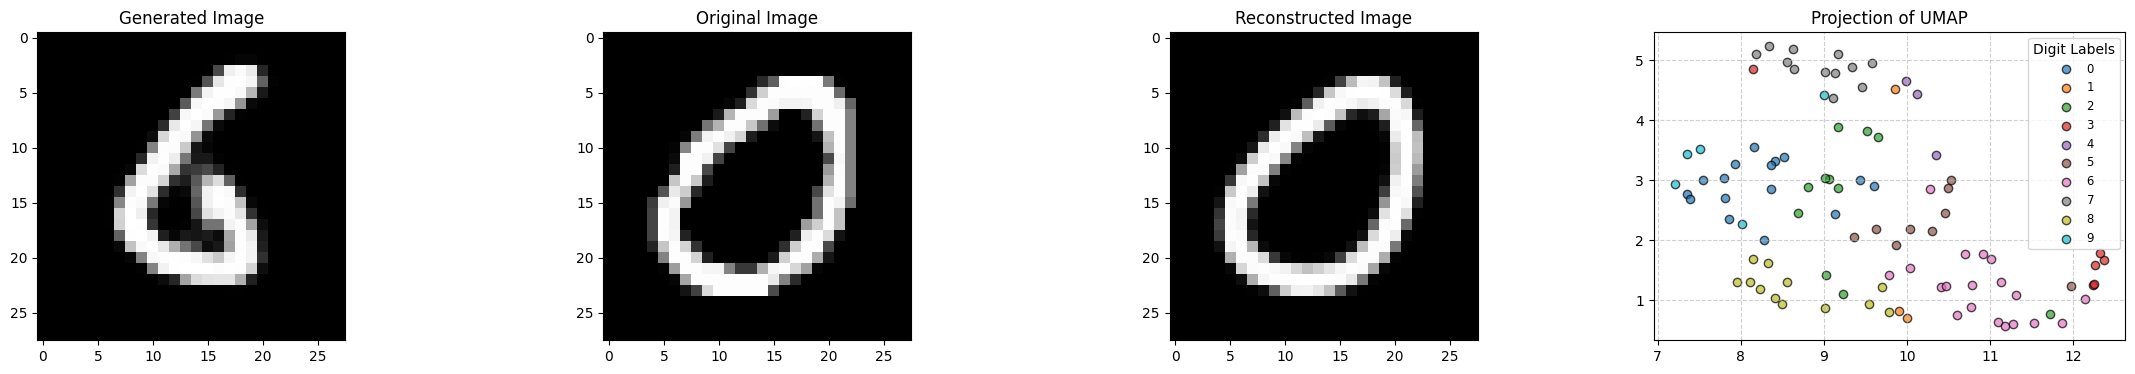

Epoch 66/50: 100%|██████████| 625/625 [00:17<00:00, 35.30it/s, loss=0.0525]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 66 Average Loss: 0.0545


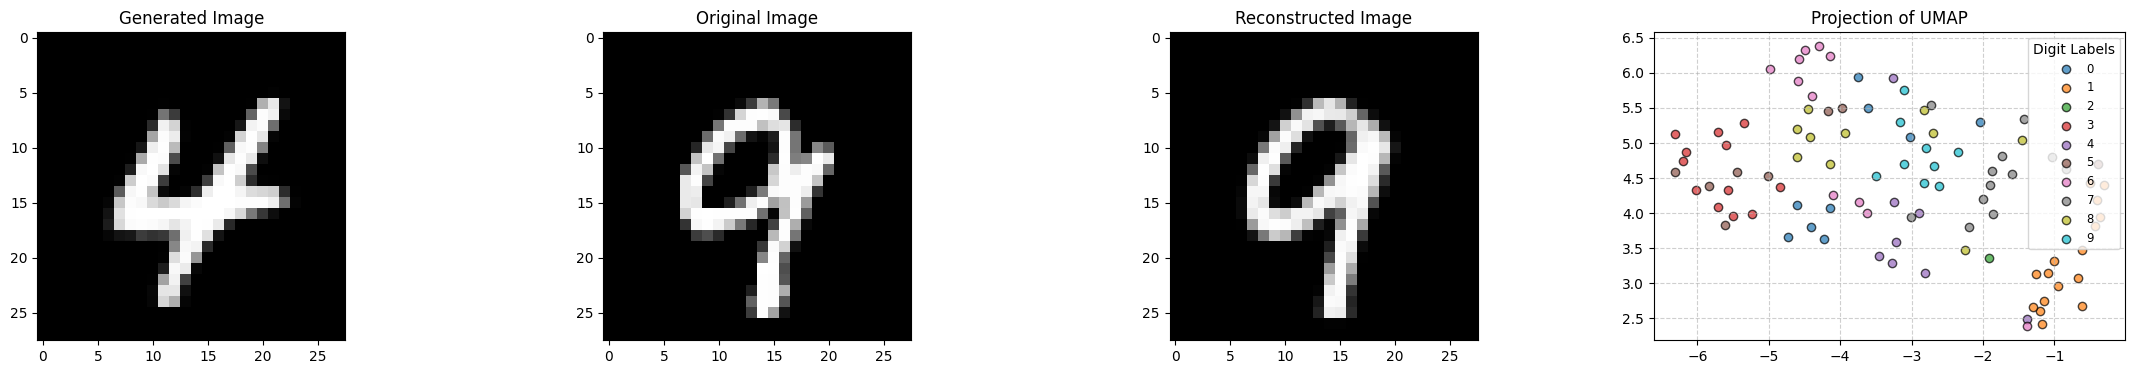

Epoch 67/50: 100%|██████████| 625/625 [00:18<00:00, 34.21it/s, loss=0.0557]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 67 Average Loss: 0.0544


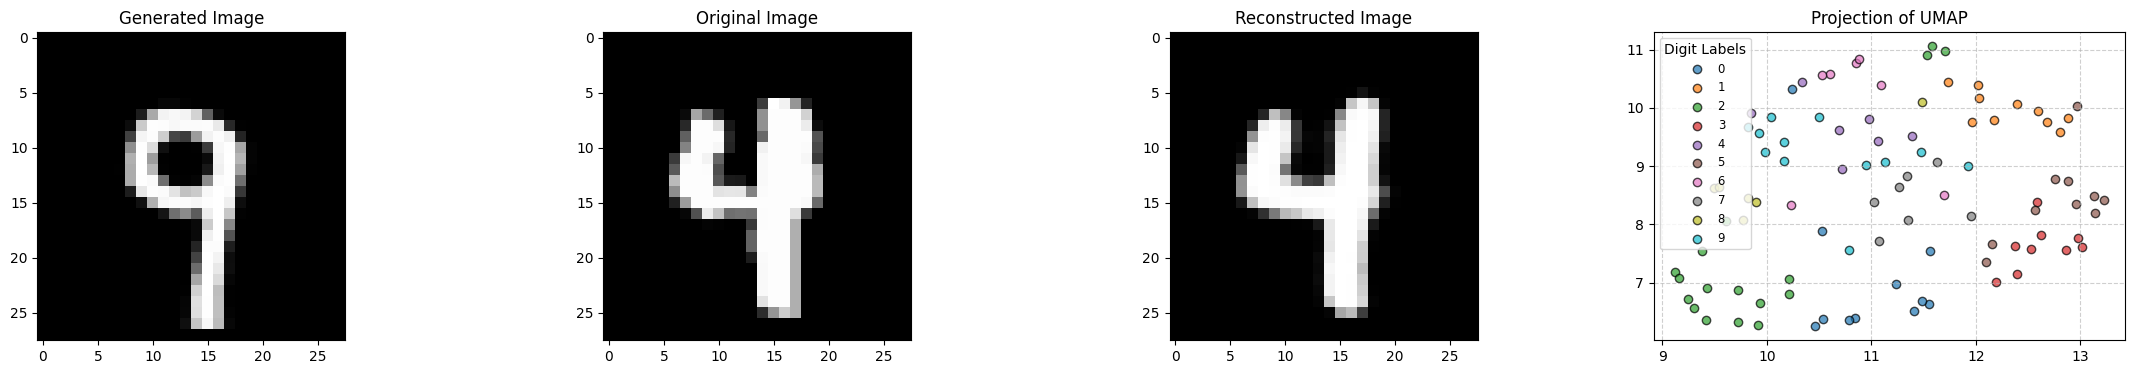

Epoch 68/50: 100%|██████████| 625/625 [00:18<00:00, 33.42it/s, loss=0.0541]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 68 Average Loss: 0.0544


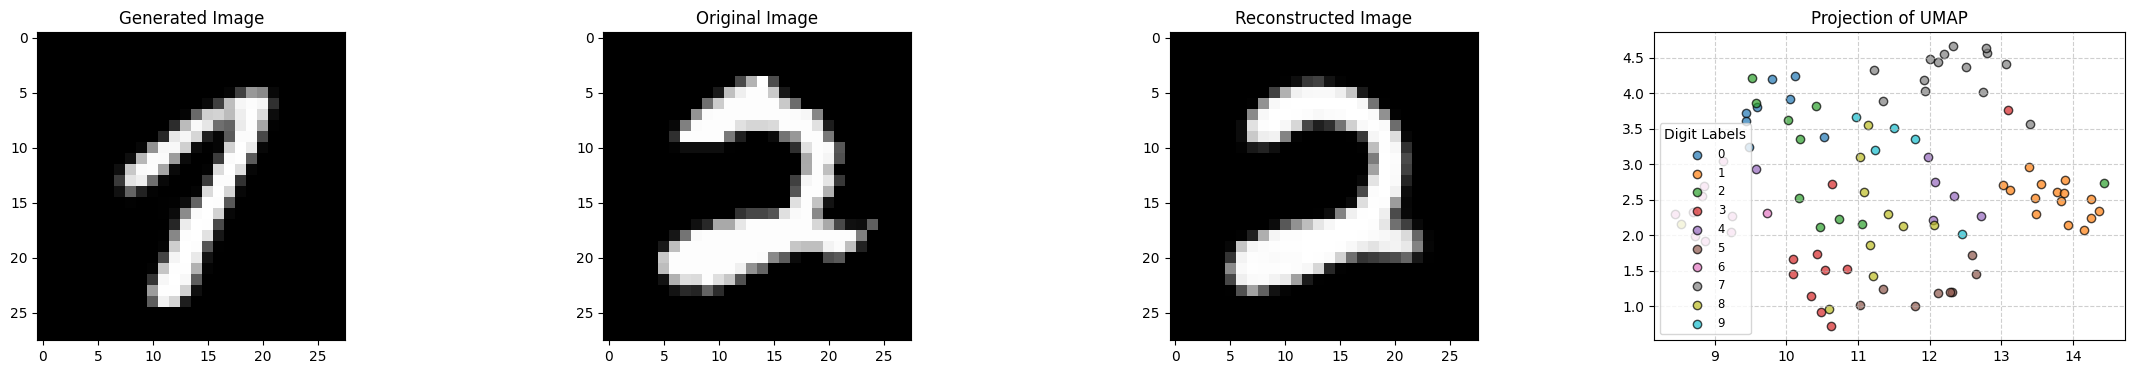

Epoch 69/50: 100%|██████████| 625/625 [00:18<00:00, 34.70it/s, loss=0.0546]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 69 Average Loss: 0.0543


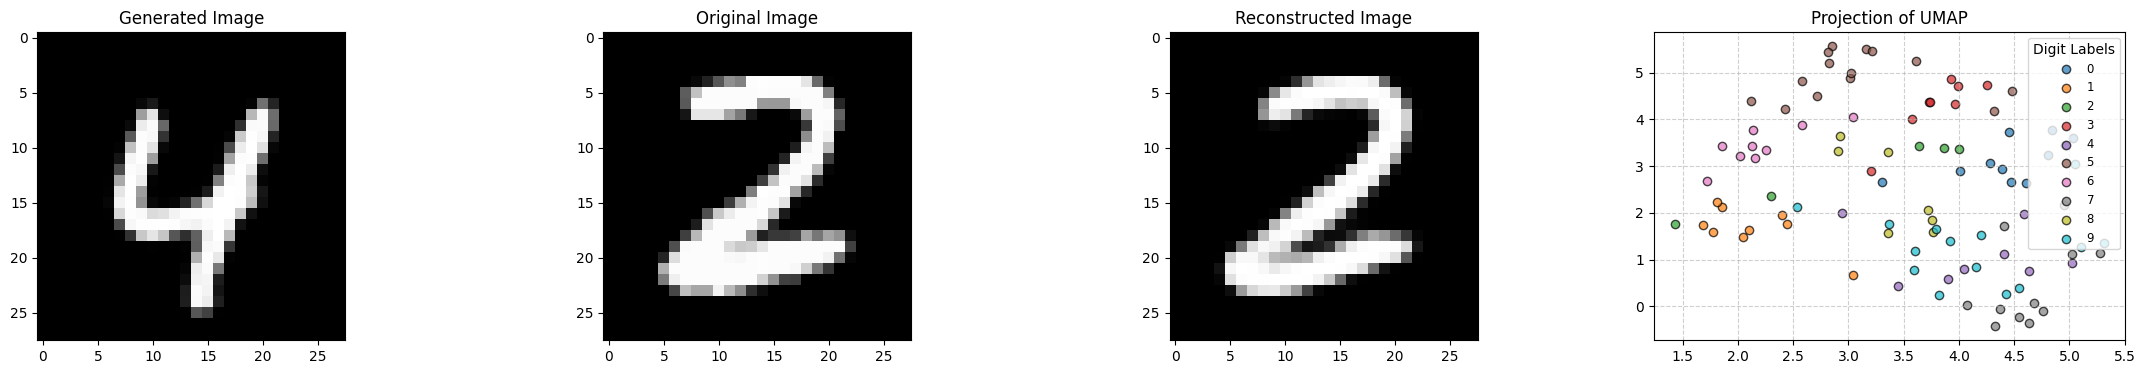

Epoch 70/50: 100%|██████████| 625/625 [00:17<00:00, 34.85it/s, loss=0.0535]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 70 Average Loss: 0.0543


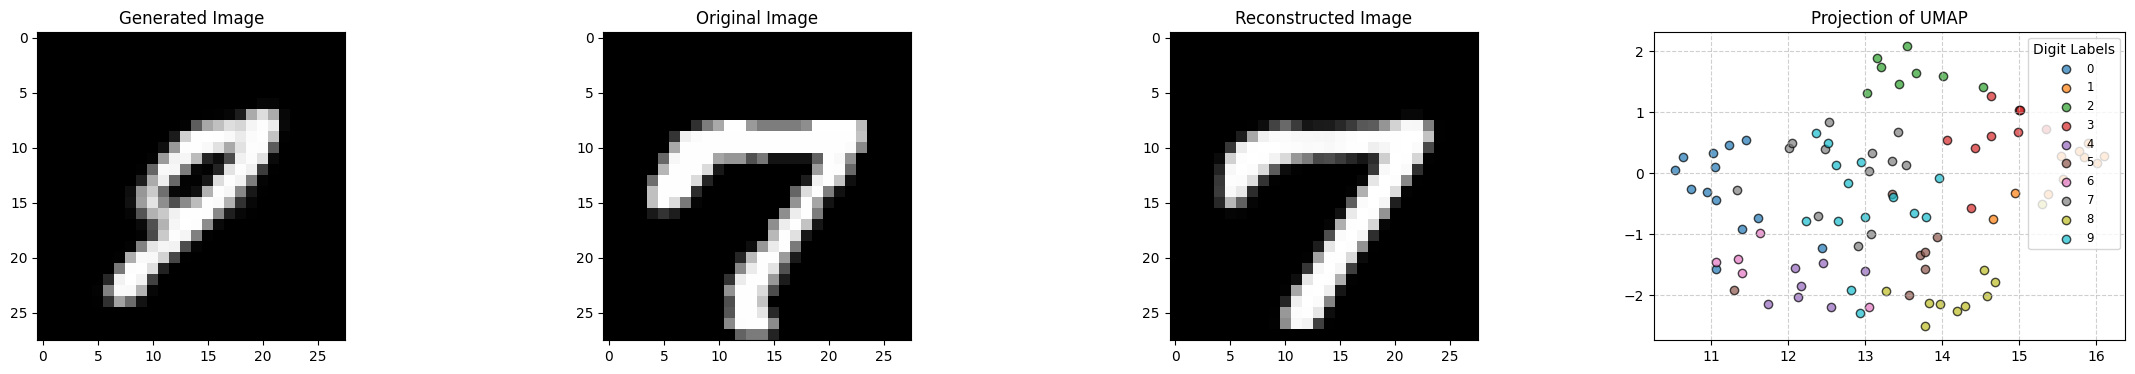

Epoch 71/50: 100%|██████████| 625/625 [00:18<00:00, 34.32it/s, loss=0.0543]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 71 Average Loss: 0.0542


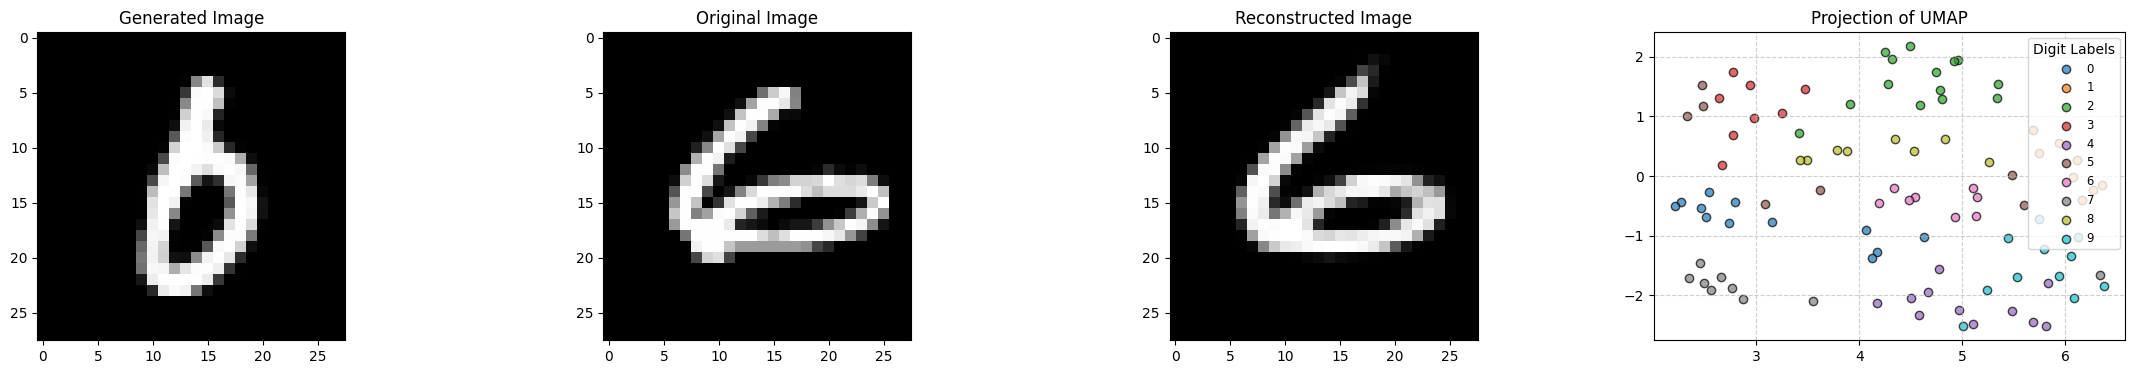

Epoch 72/50: 100%|██████████| 625/625 [00:18<00:00, 33.94it/s, loss=0.0554]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 72 Average Loss: 0.0541


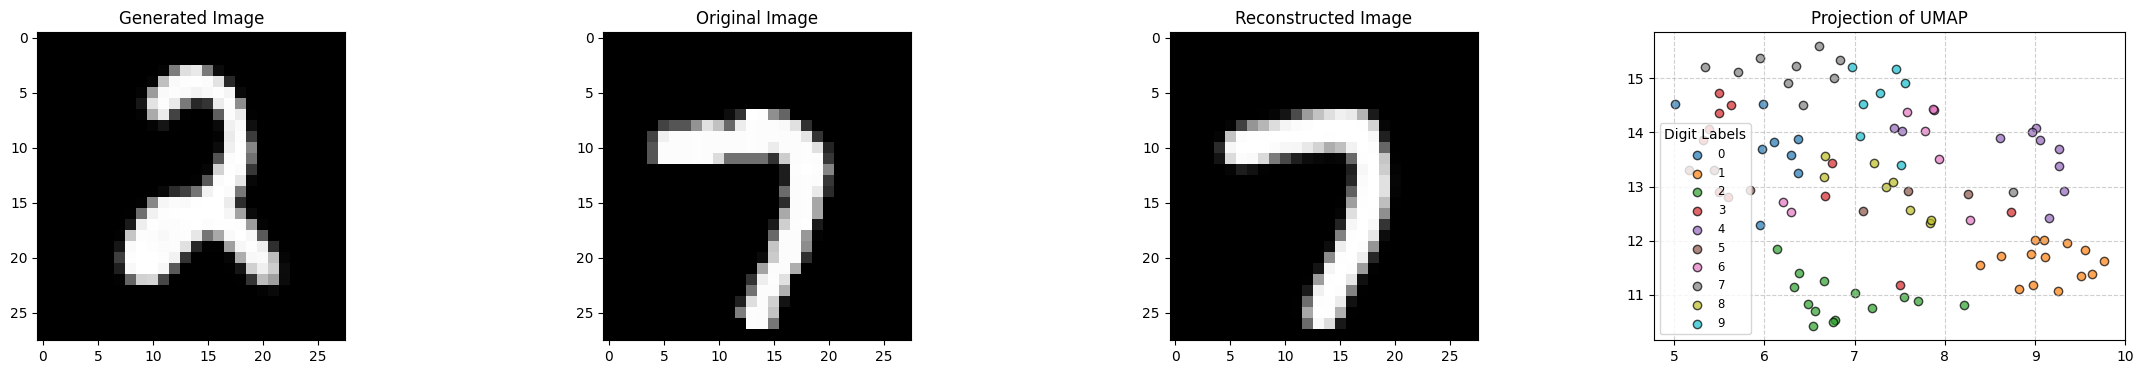

Epoch 73/50: 100%|██████████| 625/625 [00:18<00:00, 34.69it/s, loss=0.0535]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 73 Average Loss: 0.0541


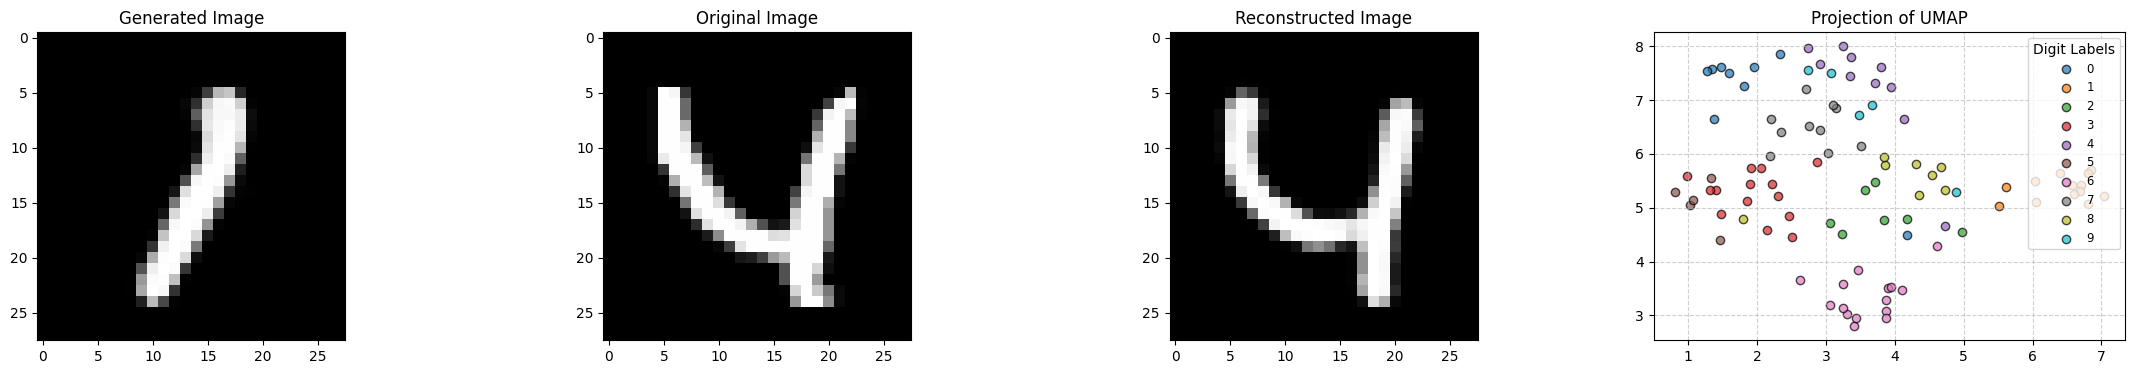

Epoch 74/50: 100%|██████████| 625/625 [00:17<00:00, 35.15it/s, loss=0.056]


Epoch 74 Average Loss: 0.0540


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


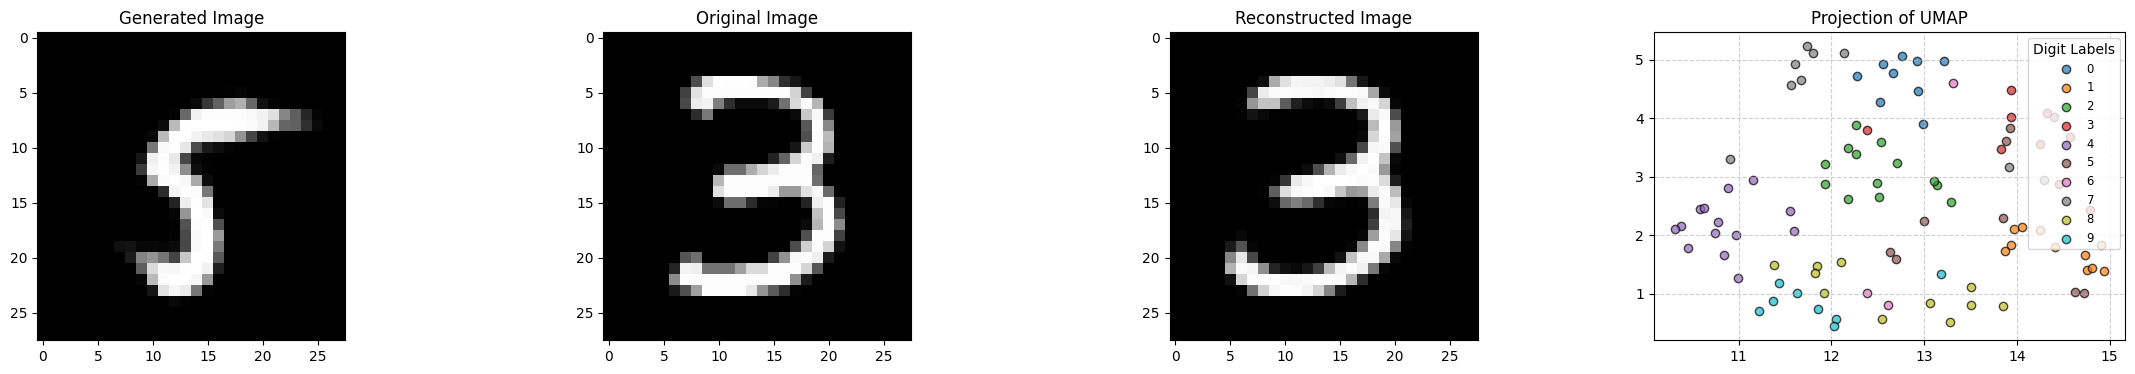

Epoch 75/50: 100%|██████████| 625/625 [00:18<00:00, 34.14it/s, loss=0.054]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 75 Average Loss: 0.0540


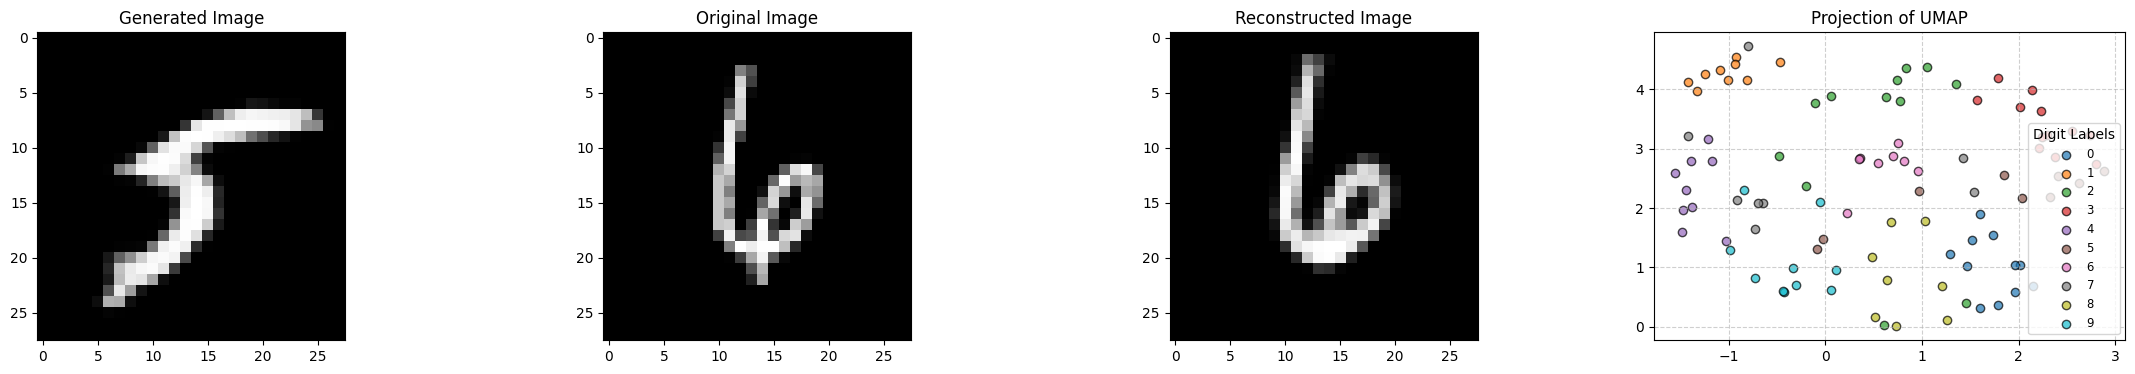

Epoch 76/50: 100%|██████████| 625/625 [00:18<00:00, 34.35it/s, loss=0.053]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 76 Average Loss: 0.0539


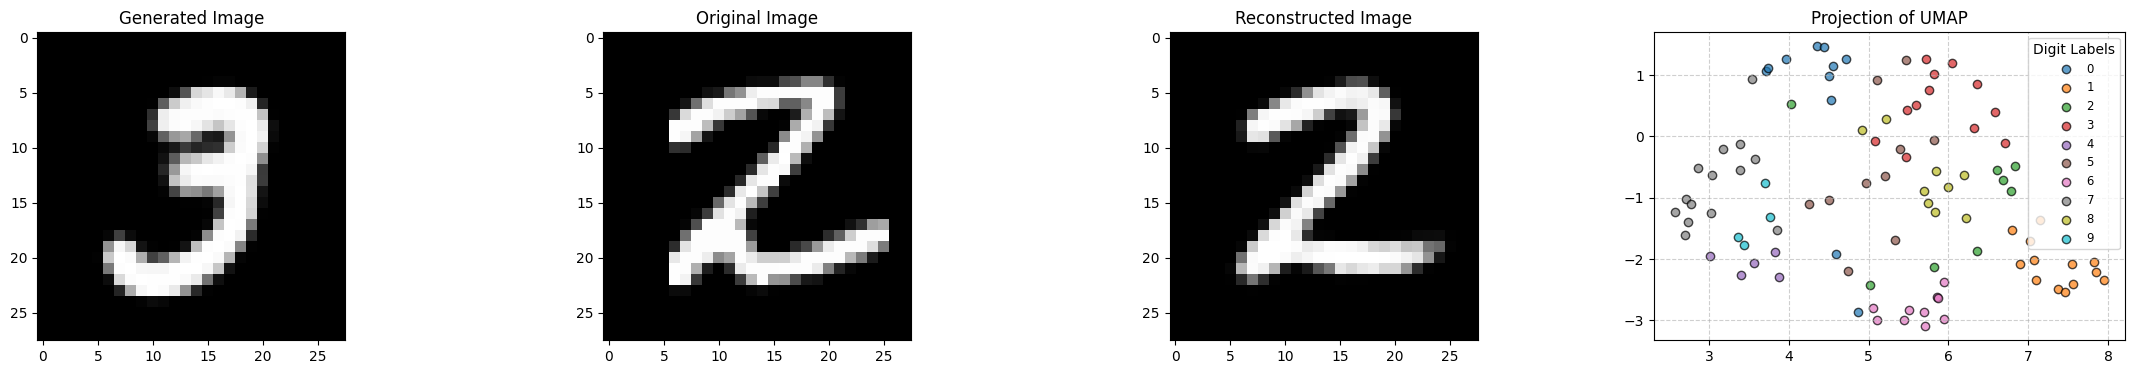

Epoch 77/50: 100%|██████████| 625/625 [00:17<00:00, 35.70it/s, loss=0.0561]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 77 Average Loss: 0.0539


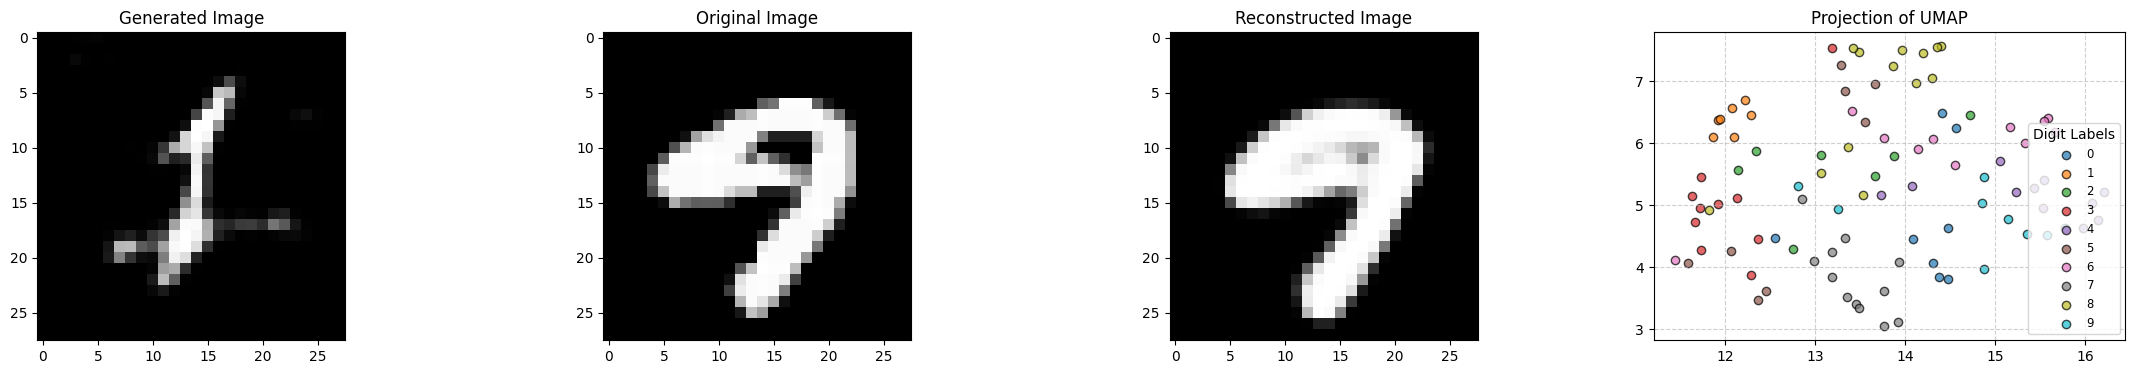

Epoch 78/50: 100%|██████████| 625/625 [00:17<00:00, 34.95it/s, loss=0.0525]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 78 Average Loss: 0.0538


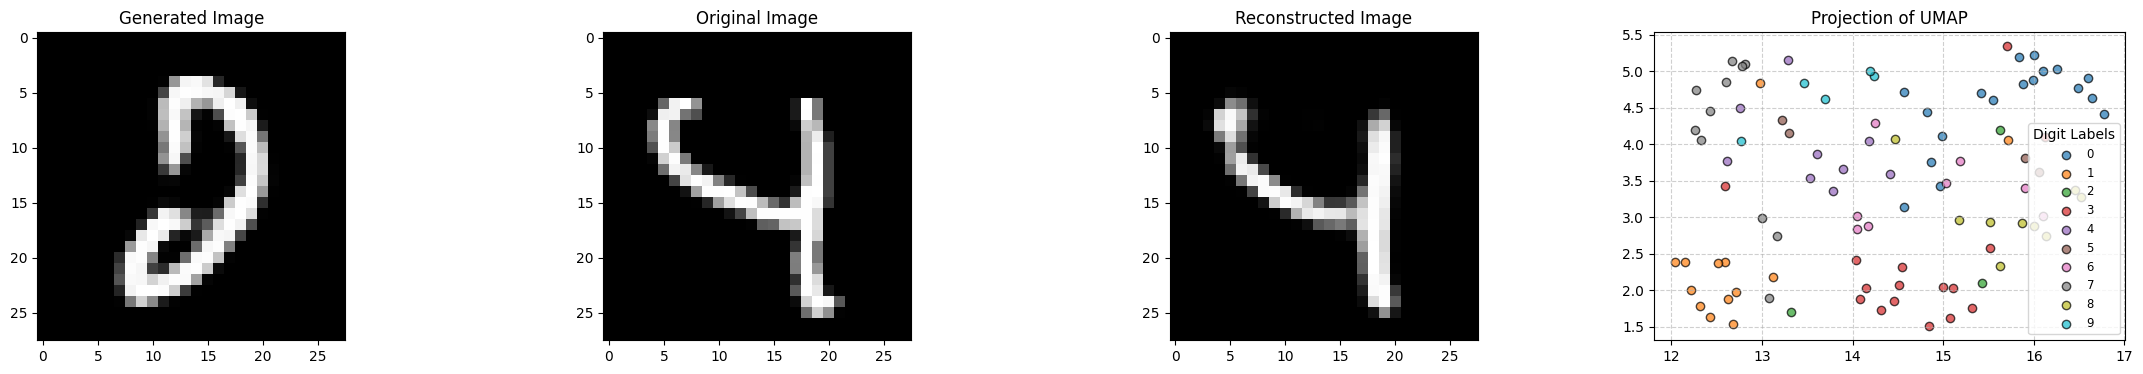

Epoch 79/50: 100%|██████████| 625/625 [00:18<00:00, 34.59it/s, loss=0.0545]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 79 Average Loss: 0.0538


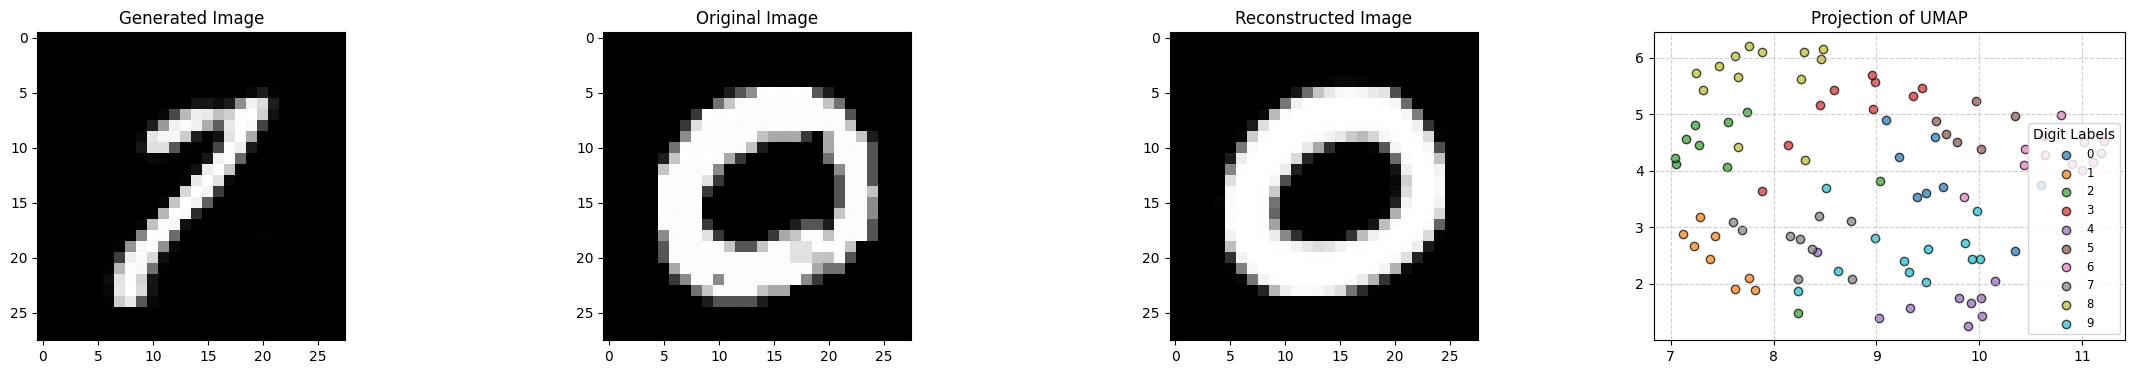

Epoch 80/50: 100%|██████████| 625/625 [00:18<00:00, 34.59it/s, loss=0.0534]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 80 Average Loss: 0.0538


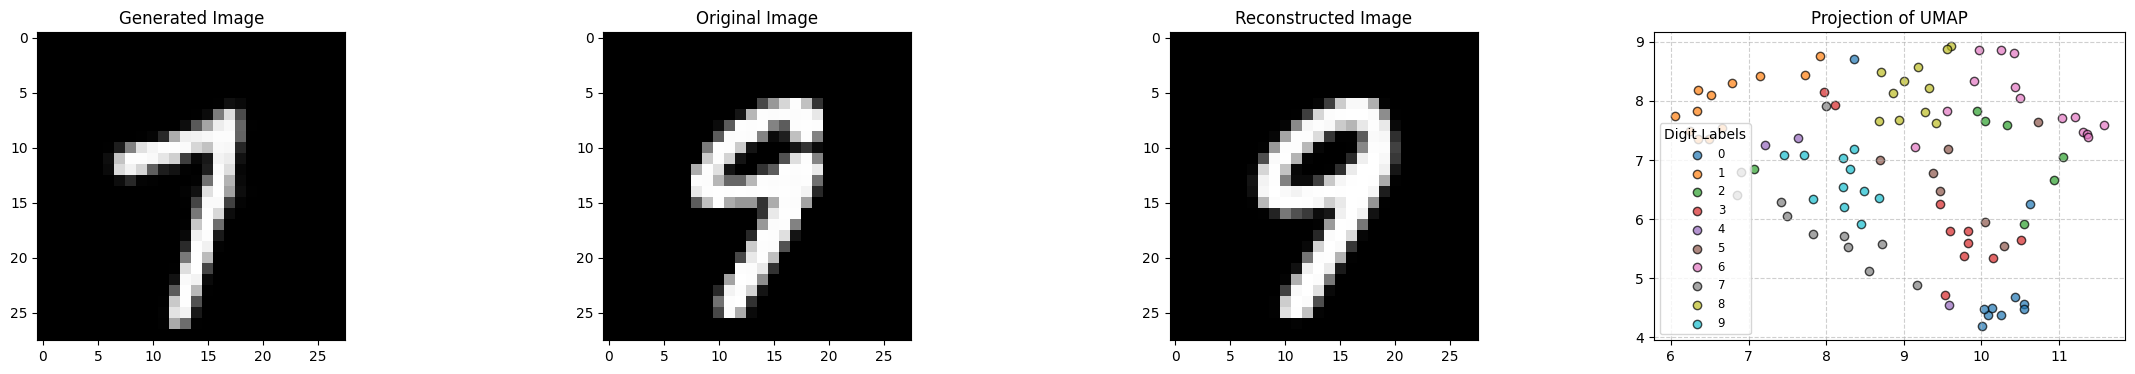

Epoch 81/50: 100%|██████████| 625/625 [00:17<00:00, 35.12it/s, loss=0.0519]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 81 Average Loss: 0.0537


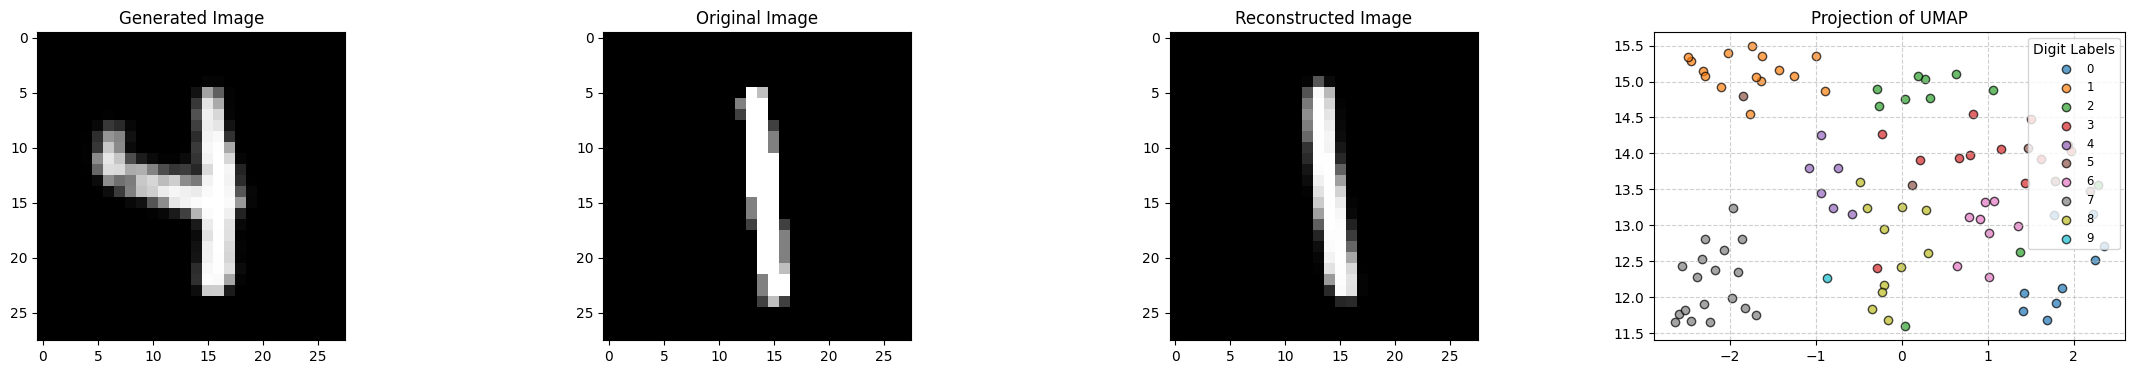

Epoch 82/50: 100%|██████████| 625/625 [00:17<00:00, 36.30it/s, loss=0.0527]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 82 Average Loss: 0.0537


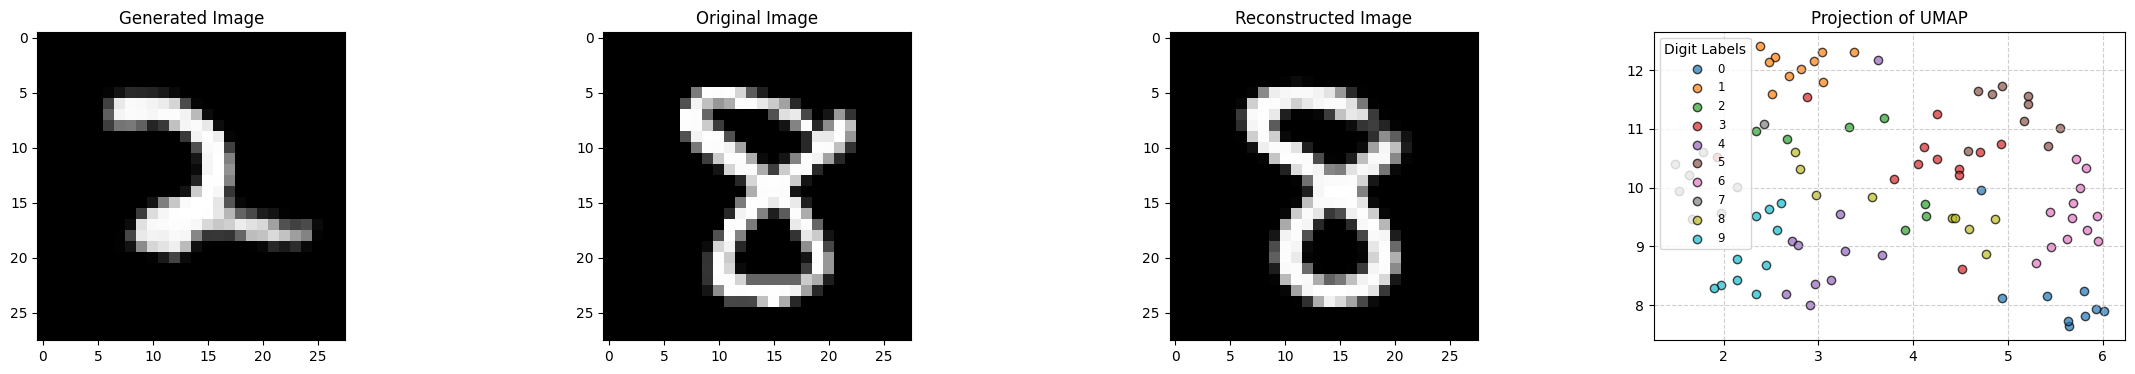

Epoch 83/50: 100%|██████████| 625/625 [00:17<00:00, 34.80it/s, loss=0.0532]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 83 Average Loss: 0.0536


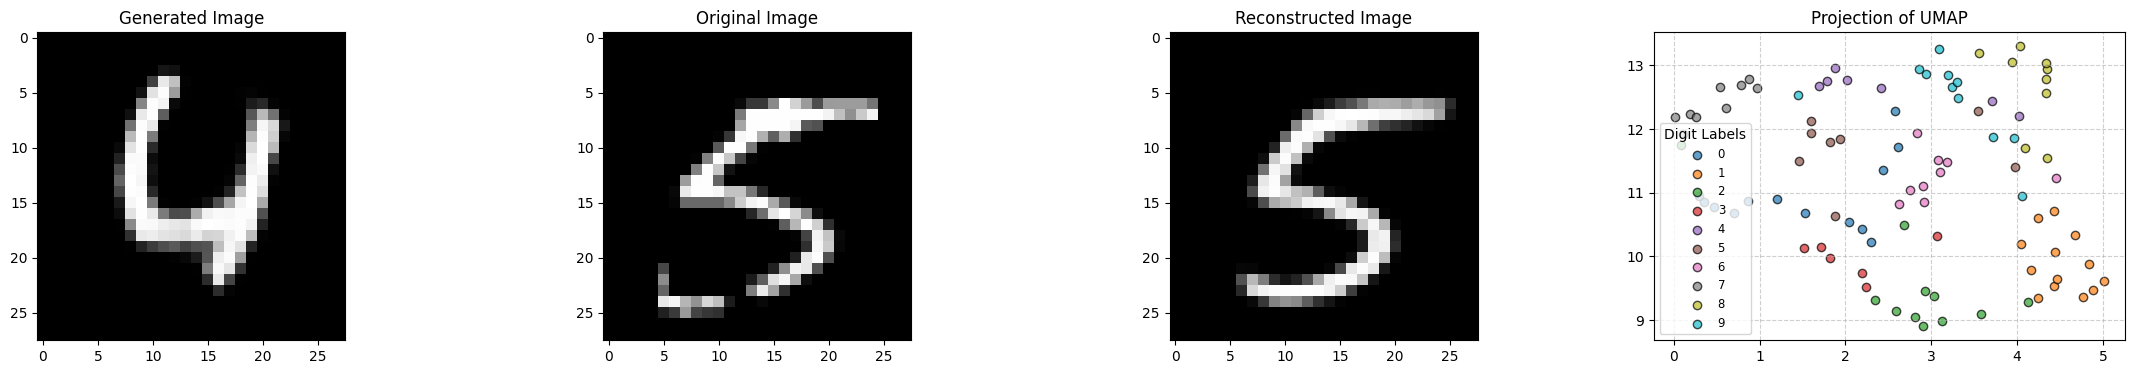

Epoch 84/50: 100%|██████████| 625/625 [00:17<00:00, 34.76it/s, loss=0.0515]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 84 Average Loss: 0.0535


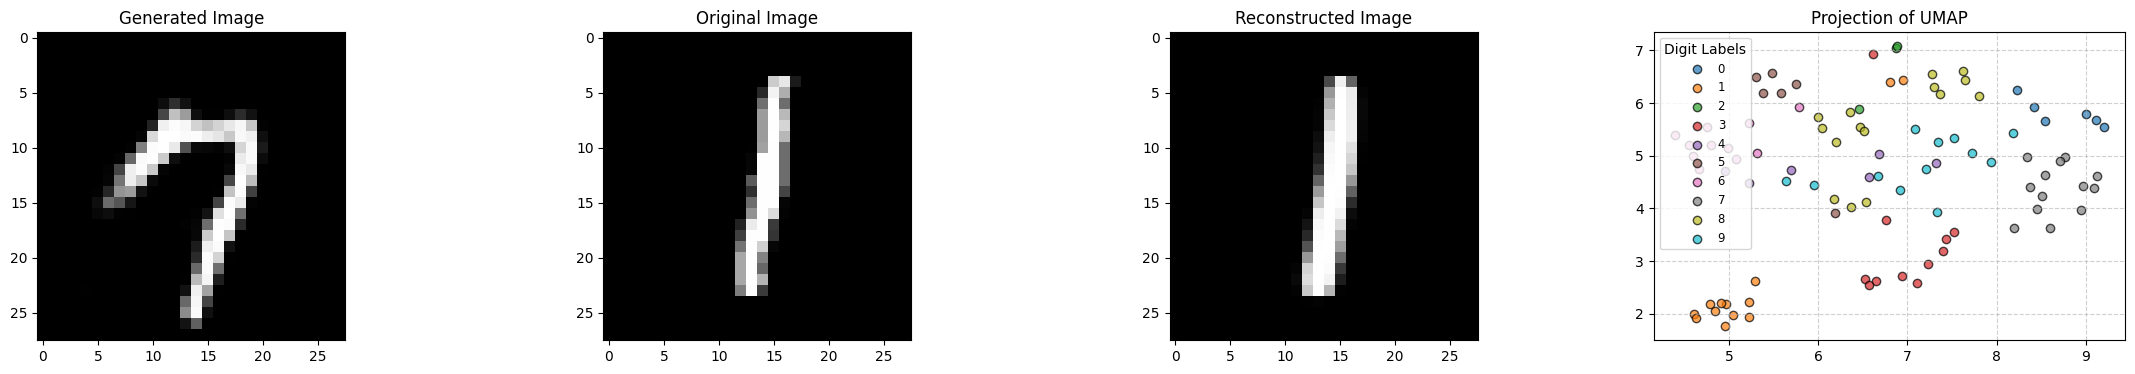

Epoch 85/50: 100%|██████████| 625/625 [00:18<00:00, 33.81it/s, loss=0.0535]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 85 Average Loss: 0.0535


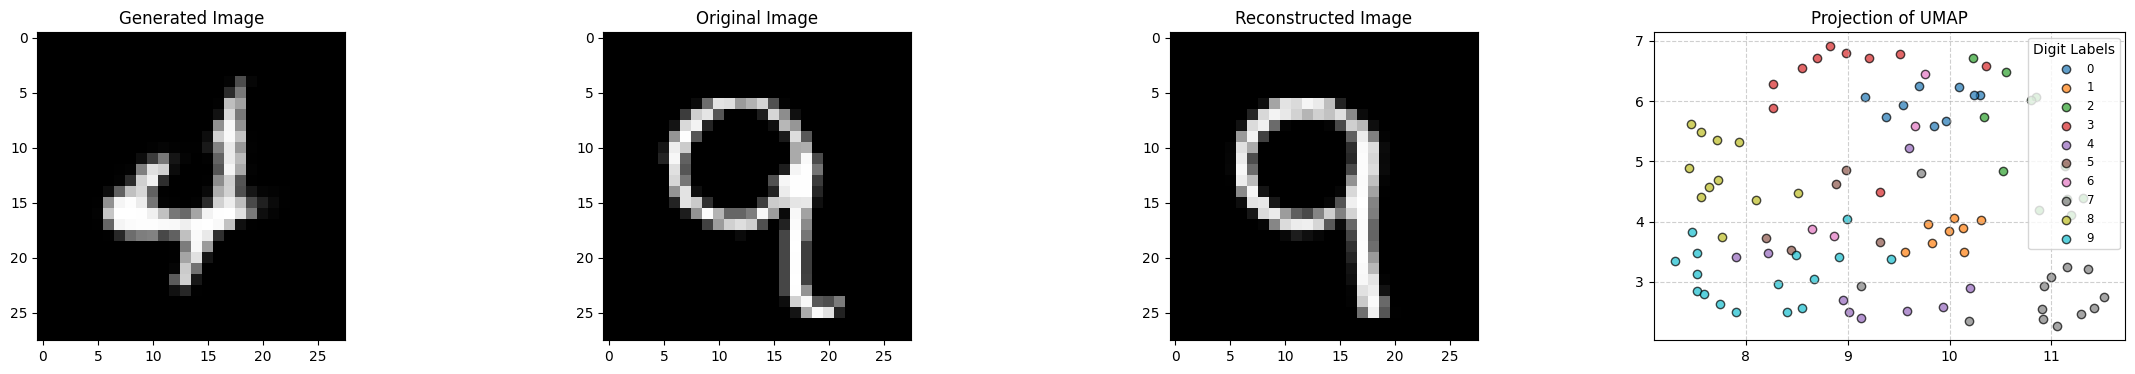

Epoch 86/50: 100%|██████████| 625/625 [00:18<00:00, 34.65it/s, loss=0.0543]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 86 Average Loss: 0.0534


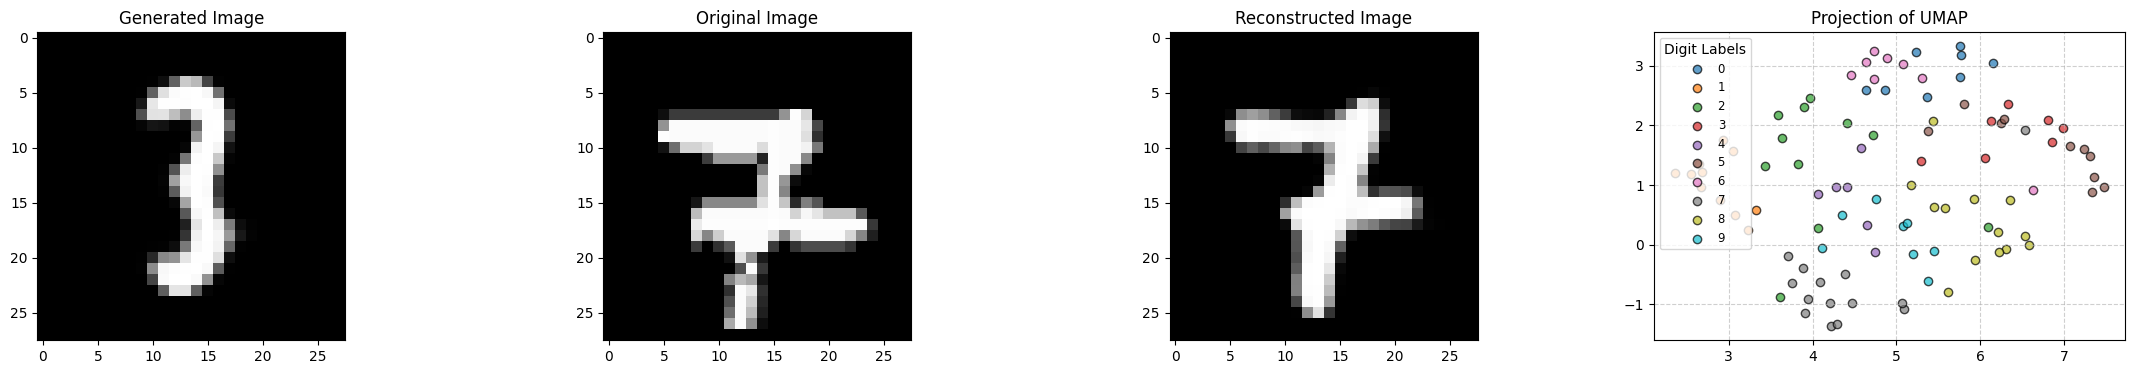

Epoch 87/50: 100%|██████████| 625/625 [00:17<00:00, 34.85it/s, loss=0.0533]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 87 Average Loss: 0.0534


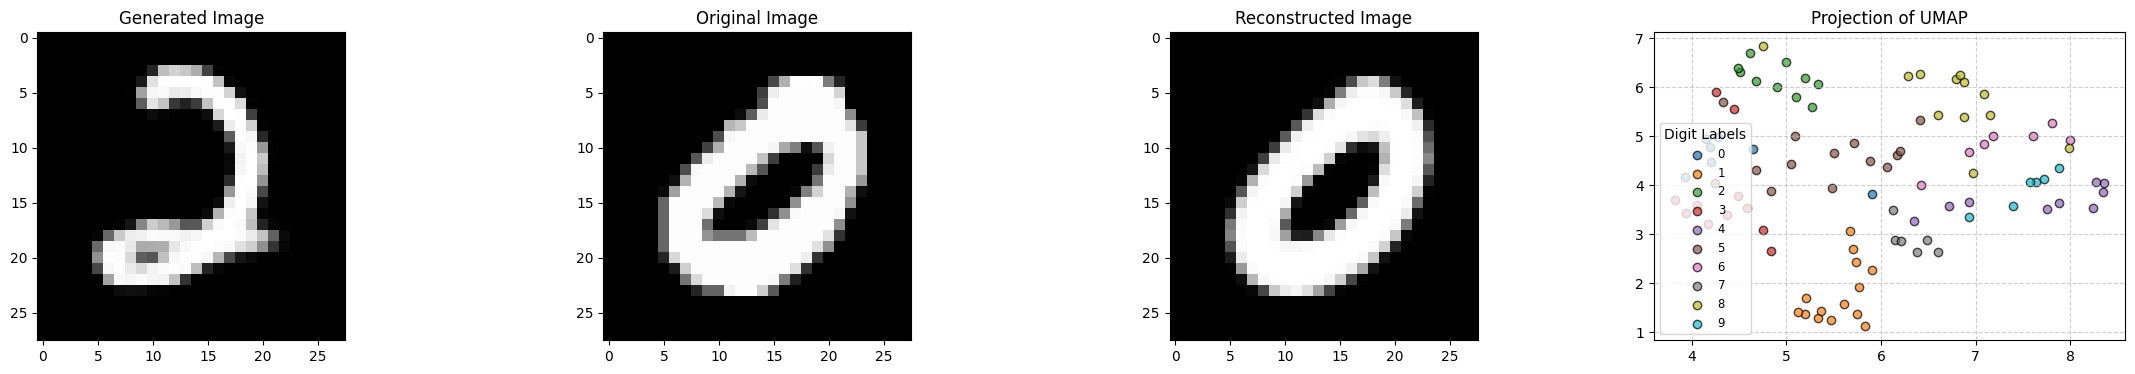

Epoch 88/50: 100%|██████████| 625/625 [00:18<00:00, 34.61it/s, loss=0.0542]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 88 Average Loss: 0.0533


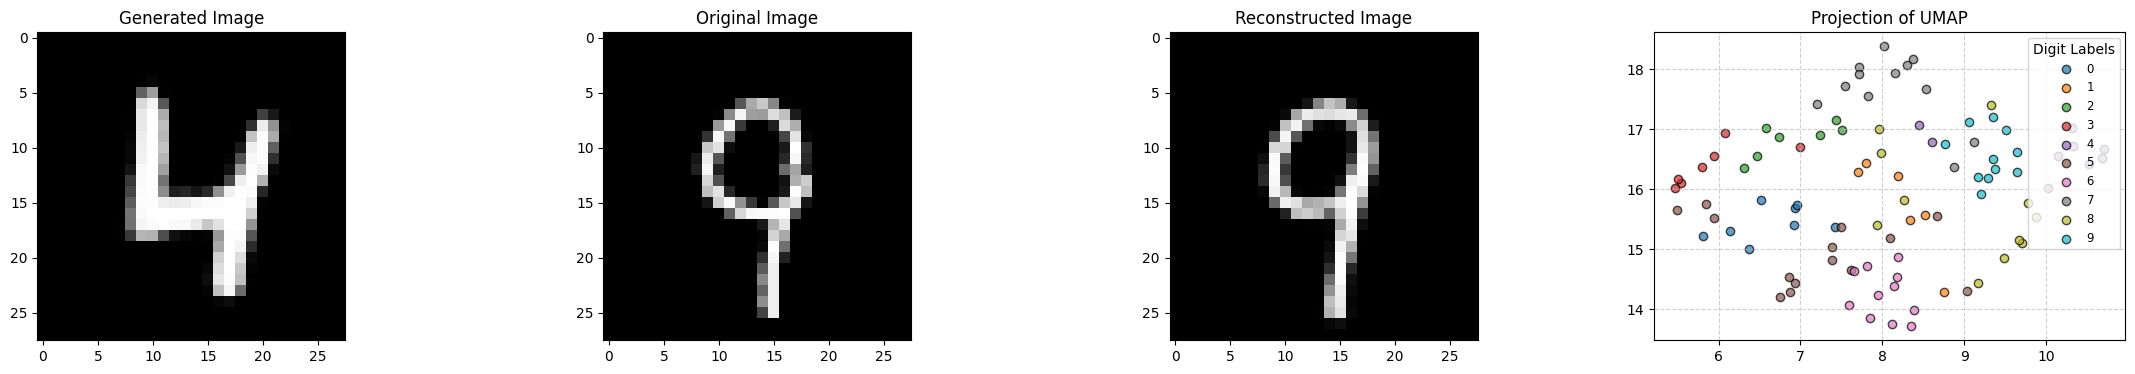

Epoch 89/50: 100%|██████████| 625/625 [00:18<00:00, 34.67it/s, loss=0.0523]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 89 Average Loss: 0.0533


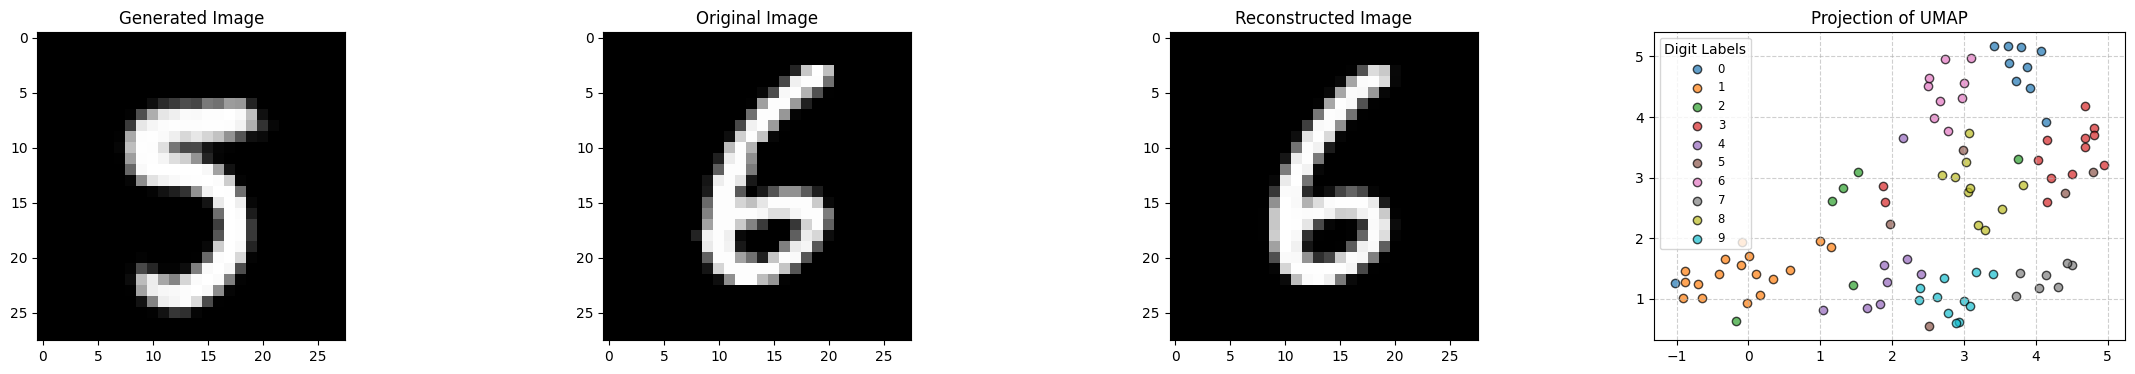

Epoch 90/50: 100%|██████████| 625/625 [00:17<00:00, 34.93it/s, loss=0.0536]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 90 Average Loss: 0.0533


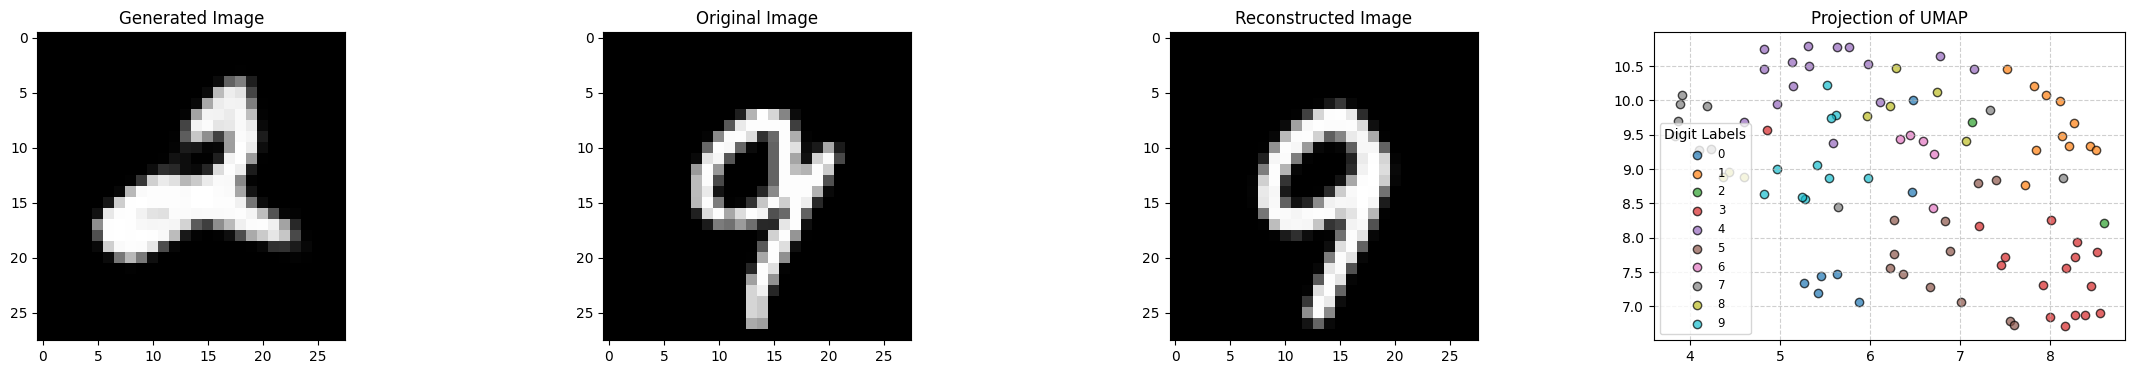

Epoch 91/50: 100%|██████████| 625/625 [00:17<00:00, 34.92it/s, loss=0.055]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 91 Average Loss: 0.0533


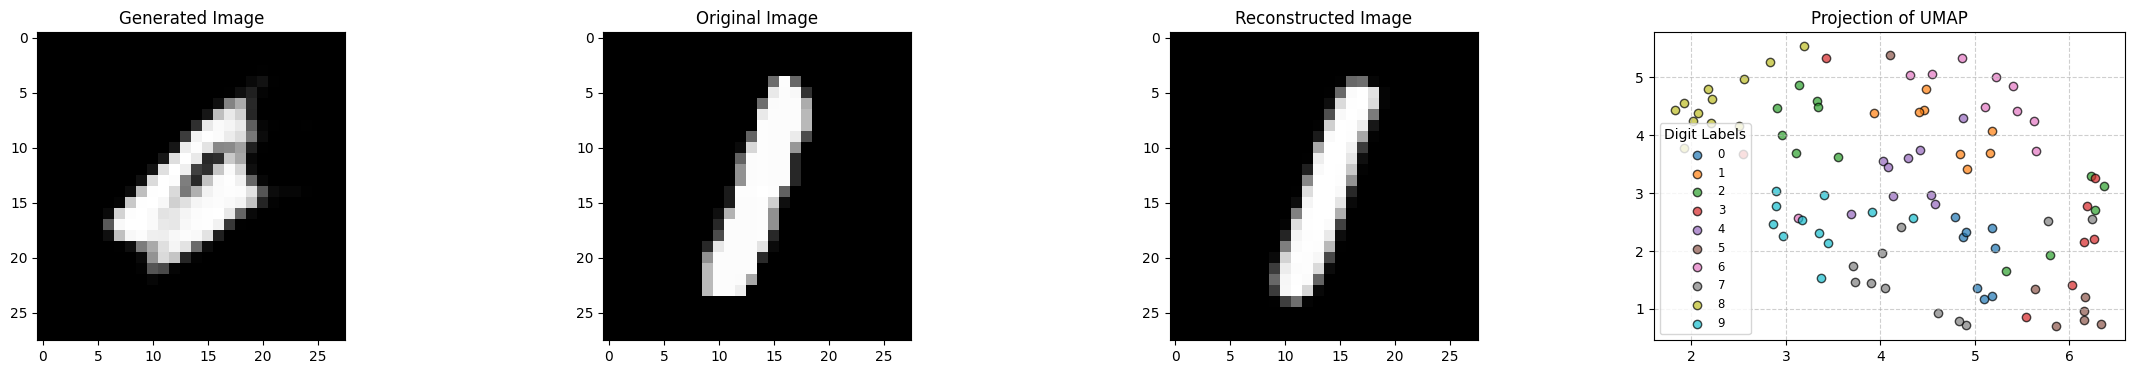

Epoch 92/50: 100%|██████████| 625/625 [00:18<00:00, 34.00it/s, loss=0.0509]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 92 Average Loss: 0.0532


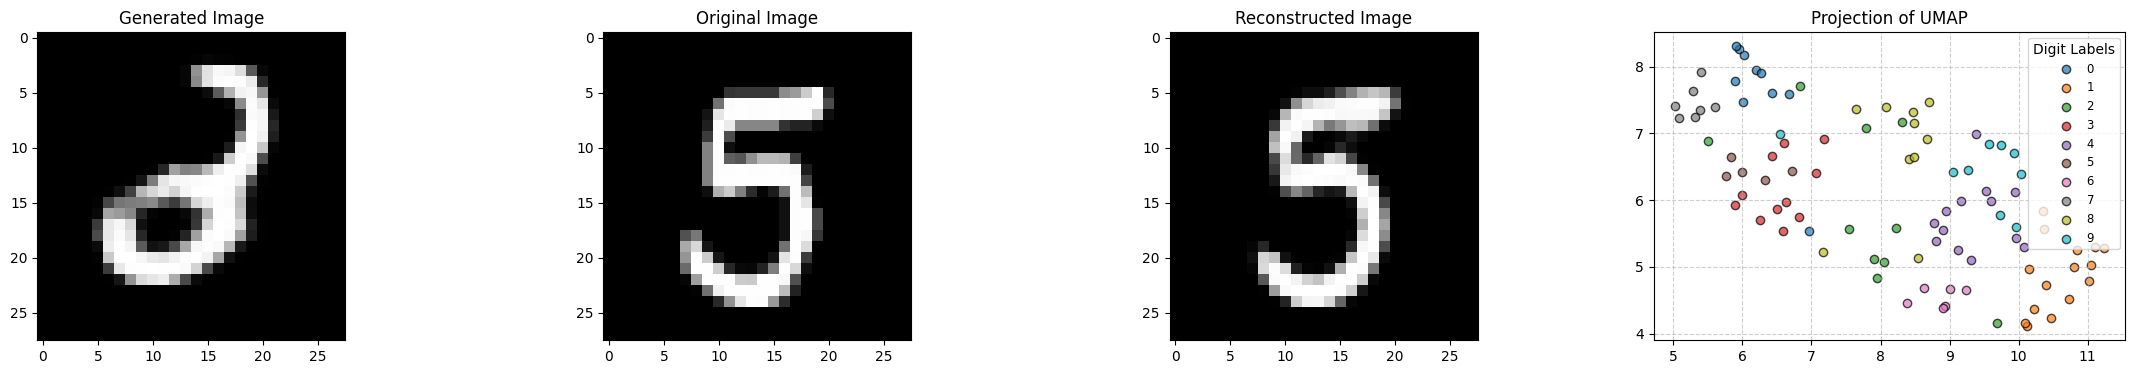

Epoch 93/50: 100%|██████████| 625/625 [00:18<00:00, 34.49it/s, loss=0.0508]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 93 Average Loss: 0.0532


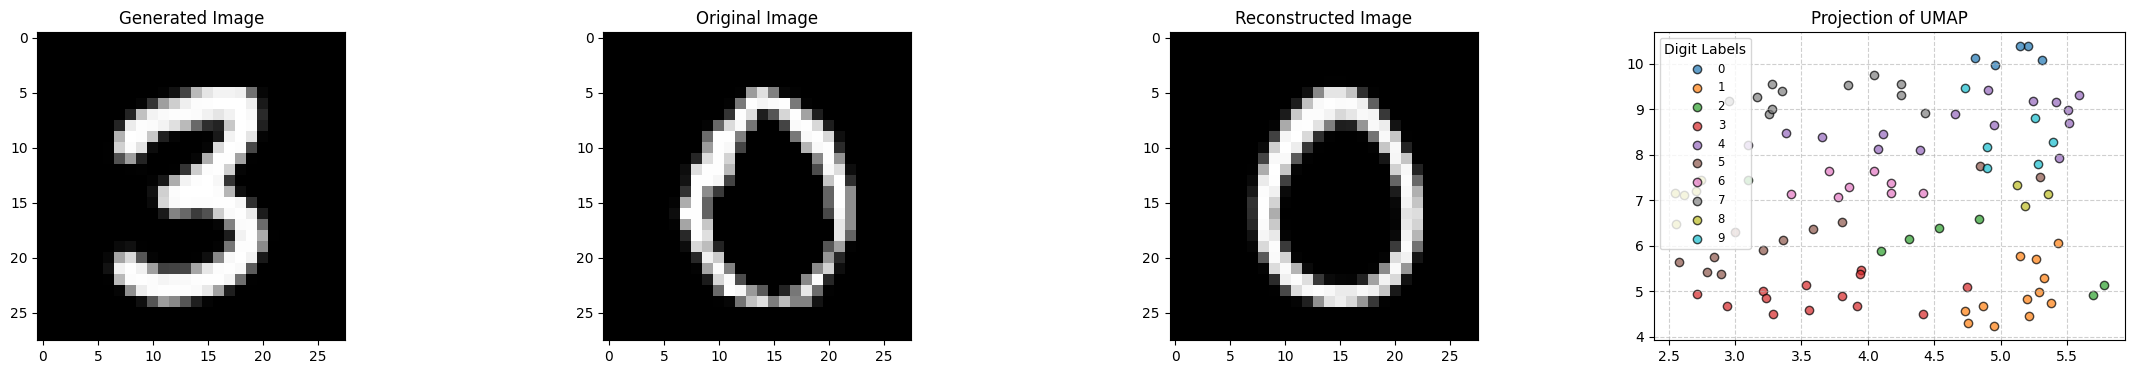

Epoch 94/50: 100%|██████████| 625/625 [00:17<00:00, 35.61it/s, loss=0.0539]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 94 Average Loss: 0.0531


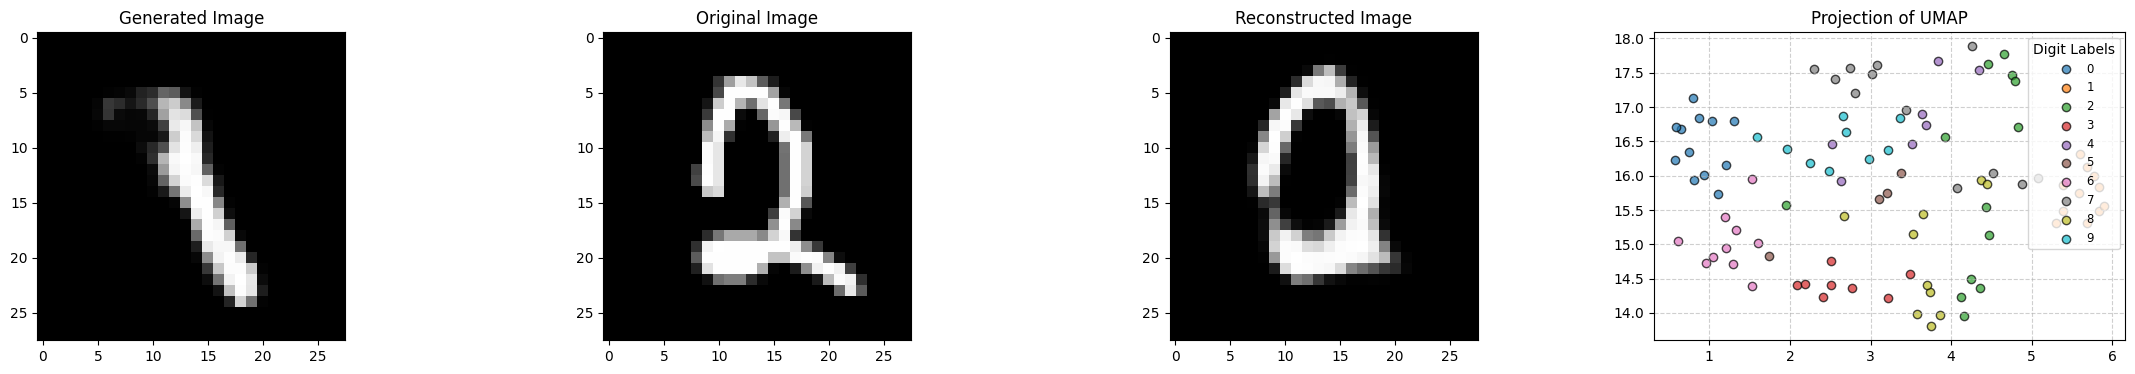

Epoch 95/50: 100%|██████████| 625/625 [00:17<00:00, 35.51it/s, loss=0.0541]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 95 Average Loss: 0.0531


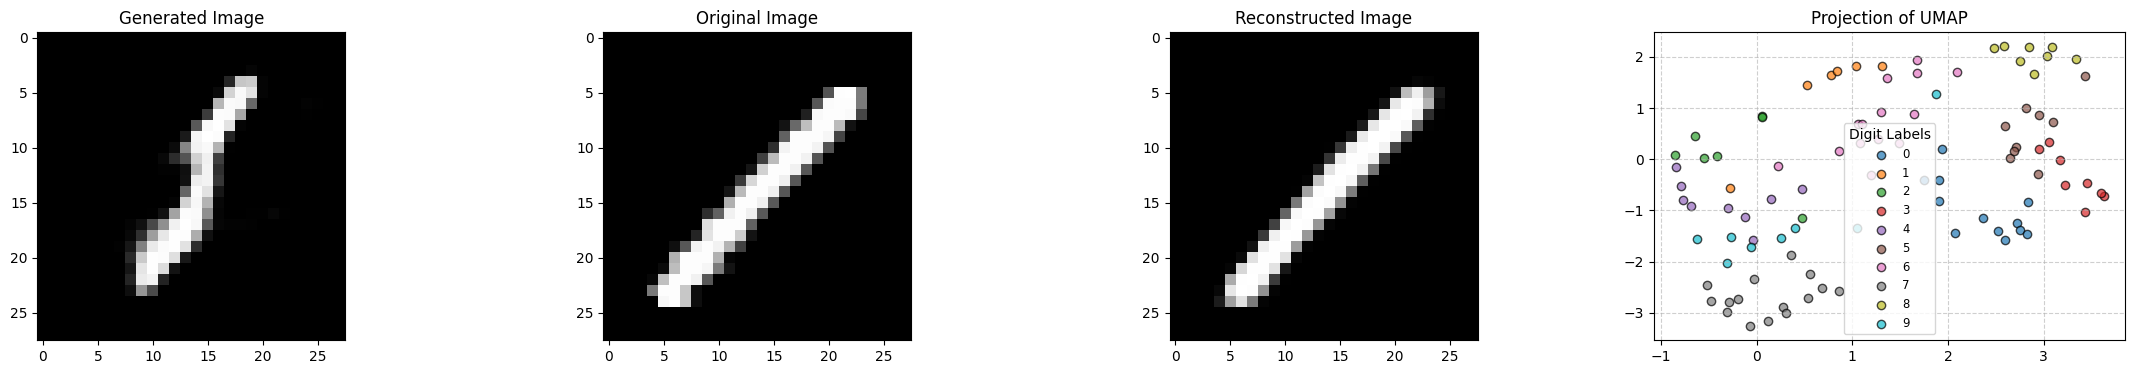

Epoch 96/50: 100%|██████████| 625/625 [00:18<00:00, 34.51it/s, loss=0.0551]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 96 Average Loss: 0.0531


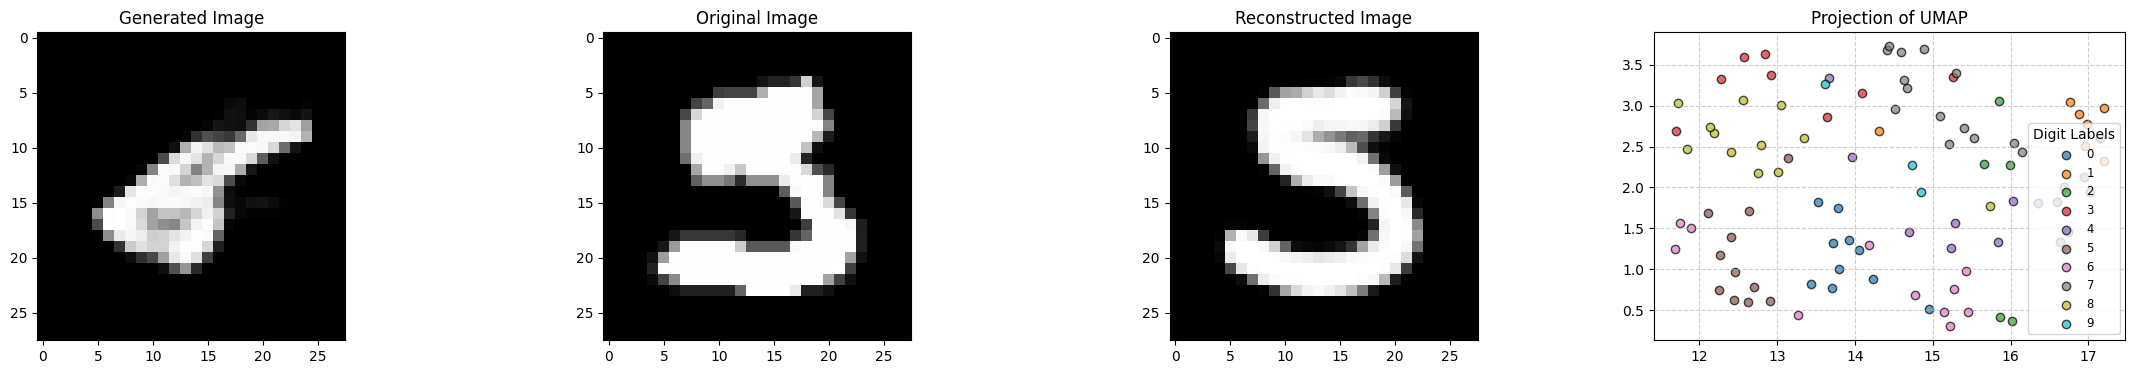

Epoch 97/50: 100%|██████████| 625/625 [00:18<00:00, 34.32it/s, loss=0.0546]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 97 Average Loss: 0.0530


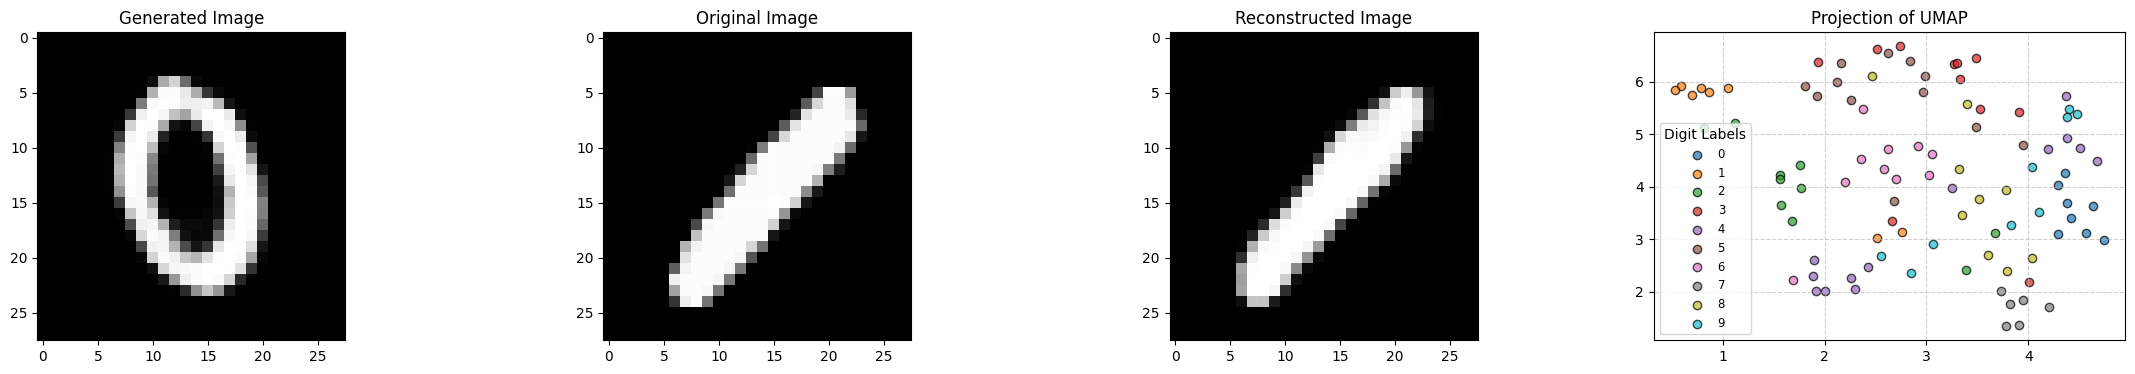

Epoch 98/50: 100%|██████████| 625/625 [00:17<00:00, 35.83it/s, loss=0.0546]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 98 Average Loss: 0.0530


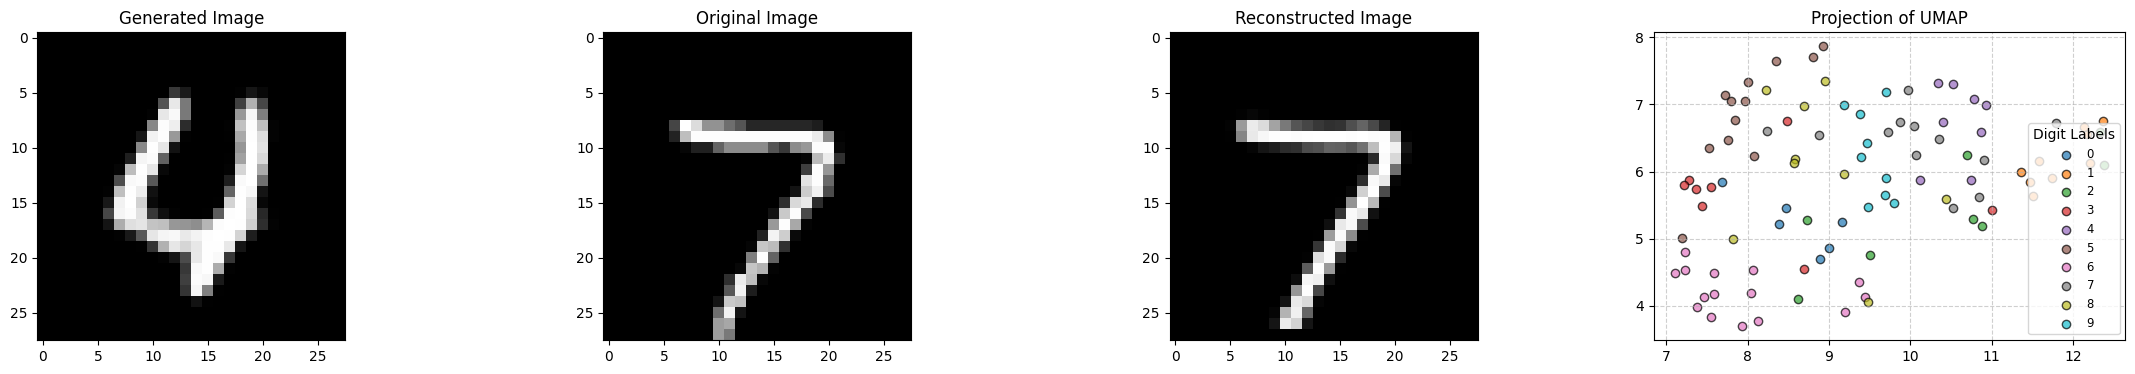

Epoch 99/50: 100%|██████████| 625/625 [00:18<00:00, 34.67it/s, loss=0.051]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 99 Average Loss: 0.0529


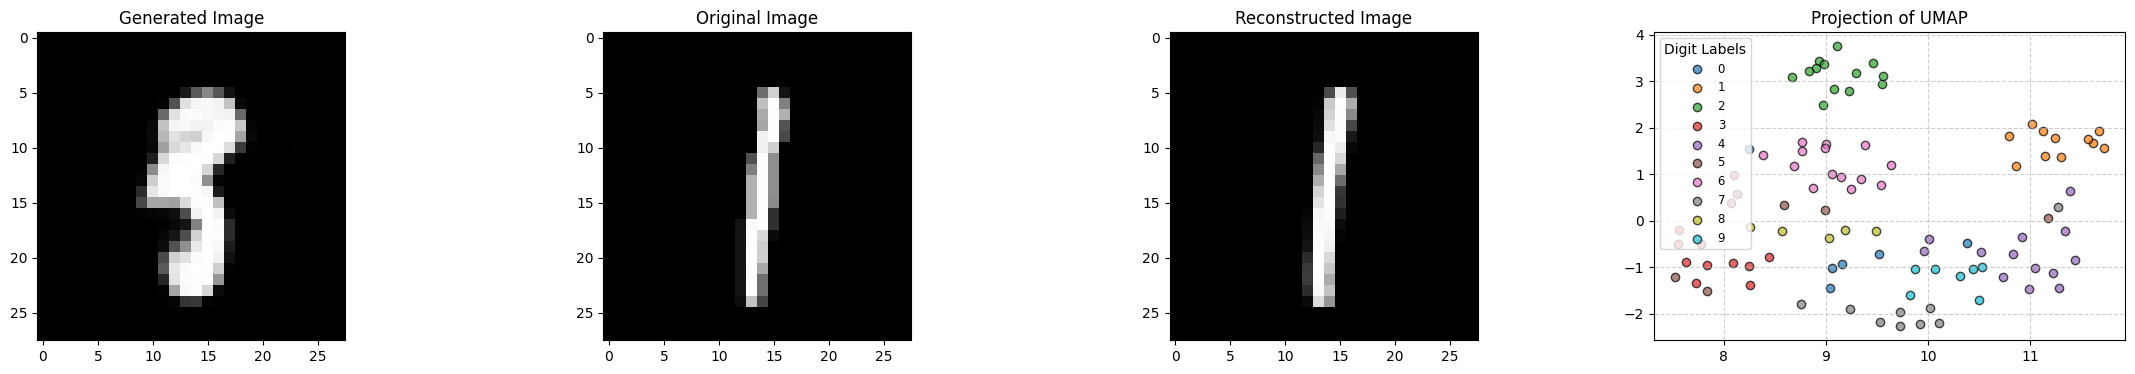

Epoch 100/50: 100%|██████████| 625/625 [00:17<00:00, 35.42it/s, loss=0.0534]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 100 Average Loss: 0.0529


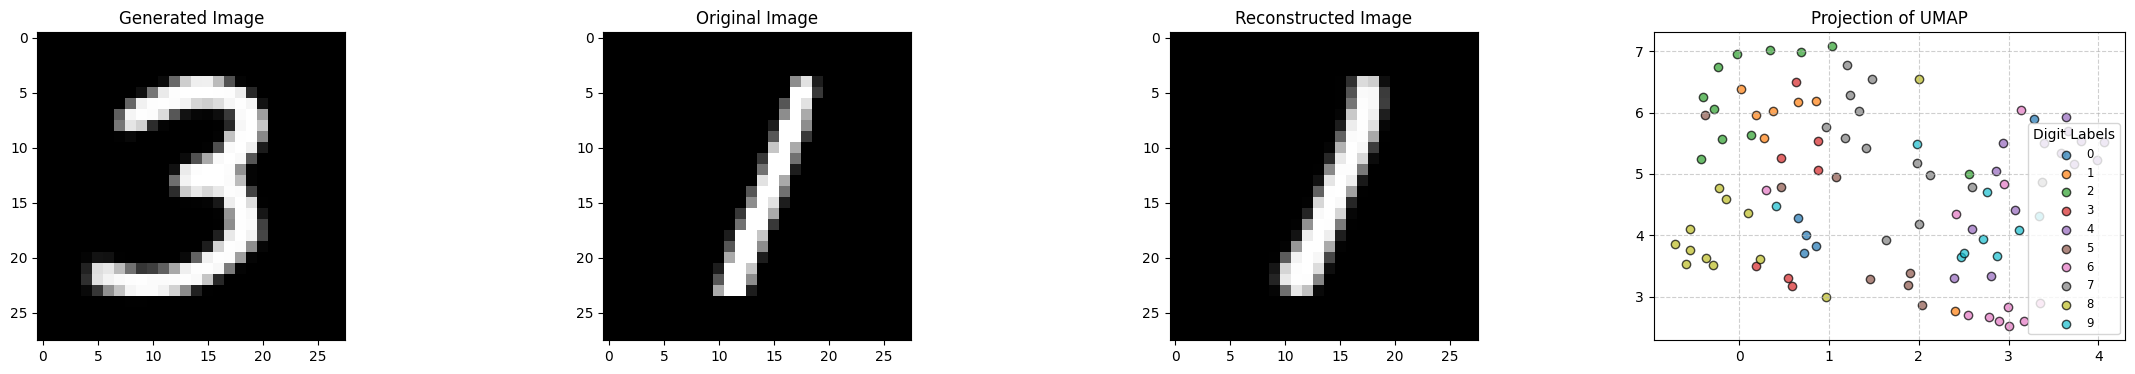

In [ ]:
for epoch in range(50, num_epochs + 50):
    running_loss = 0.0
    _labels, inputs = None, None
    with tqdm.tqdm(enumerate(train_loader, 0), total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}") as pbar:
        for i, data in pbar:
            inputs = data[0].to(device)
            _labels = data[1]
            optimizer.zero_grad()

            x_reconstructed, mu, log_var = model(inputs)
            reconstruction_loss = loss_fn(x_reconstructed, inputs)
            x_reconstructed = F.sigmoid(x_reconstructed)
            dkl_loss = -0.5 * torch.mean(torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=[1]))
            #dkl_loss = 0.5 * torch.mean(torch.sum(mu.pow(2), dim=[1]))
            bound = 0.0 if epoch < 10 else 1.0
            beta = min(bound, epoch / num_epochs)
            # Linearly increasing KL weigth, notice we use Beta-VAE and use a small weight of DKL anyways.
            # But the beta here isn't used to minimize the entanglement, but to focus on the reconstruction.
            loss = reconstruction_loss + 1e-3 * beta * dkl_loss

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix(loss=loss.item(), refresh=True)

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch + 1} Average Loss: {avg_loss:.4f}")

    fig, axes = plt.subplots(1, 4, figsize=(28, 4))
    axes[0].imshow(model.decode(torch.randn(1, latent_shape[0], device=device)).squeeze().cpu().detach().numpy(), cmap='gray')
    axes[0].set_title('Generated Image')
    axes[1].imshow(inputs[0].squeeze().cpu().detach().numpy(), cmap='gray')
    axes[1].set_title('Original Image')
    axes[2].imshow(x_reconstructed[0].squeeze().cpu().detach().numpy(), cmap='gray')
    axes[2].set_title('Reconstructed Image')

    mu_2d = reducer.fit_transform(mu.cpu().detach().numpy().reshape(96, -1))
    labels_np = np.array(_labels)
    for label in range(10):
        axes[3].scatter(
            mu_2d[labels_np == label, 0], mu_2d[labels_np == label, 1],
            color=palette[label], label=str(label), alpha=0.7, edgecolors='k'
        )
    axes[3].set_title("Projection of UMAP")
    axes[3].legend(title="Digit Labels", loc="best", fontsize="small")
    axes[3].grid(True, linestyle="--", alpha=0.6)

    plt.show()

In [ ]:
torch.save(model, "vae_model.pth")

# Original

In [ ]:
for epoch in range(50, num_epochs + 50):
    running_loss = 0.0
    _labels, inputs = None, None
    with tqdm.tqdm(enumerate(train_loader, 0), total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}") as pbar:
        for i, data in pbar:
            inputs = data[0].to(device)
            _labels = data[1]
            optimizer.zero_grad()

            x_reconstructed, mu, log_var = model(inputs)
            reconstruction_loss = loss_fn(x_reconstructed, inputs)
            x_reconstructed = F.sigmoid(x_reconstructed)
            dkl_loss = -0.5 * torch.mean(torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=[1]))
            #dkl_loss = 0.5 * torch.mean(torch.sum(mu.pow(2), dim=[1]))
            bound = 0.0 if epoch < 10 else 1.0
            beta = min(bound, epoch / num_epochs)
            # Linearly increasing KL weigth, notice we use Beta-VAE and use a small weight of DKL anyways.
            # But the beta here isn't used to minimize the entanglement, but to focus on the reconstruction.
            loss = reconstruction_loss + 1e-3 * beta * dkl_loss

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix(loss=loss.item(), refresh=True)

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch + 1} Average Loss: {avg_loss:.4f}")

    fig, axes = plt.subplots(1, 4, figsize=(28, 4))
    axes[0].imshow(model.decode(torch.randn(1, latent_shape[0], device=device)).squeeze().cpu().detach().numpy(), cmap='gray')
    axes[0].set_title('Generated Image')
    axes[1].imshow(inputs[0].squeeze().cpu().detach().numpy(), cmap='gray')
    axes[1].set_title('Original Image')
    axes[2].imshow(x_reconstructed[0].squeeze().cpu().detach().numpy(), cmap='gray')
    axes[2].set_title('Reconstructed Image')

    mu_2d = reducer.fit_transform(mu.cpu().detach().numpy().reshape(96, -1))
    labels_np = np.array(_labels)
    for label in range(10):
        axes[3].scatter(
            mu_2d[labels_np == label, 0], mu_2d[labels_np == label, 1],
            color=palette[label], label=str(label), alpha=0.7, edgecolors='k'
        )
    axes[3].set_title("Projection of UMAP")
    axes[3].legend(title="Digit Labels", loc="best", fontsize="small")
    axes[3].grid(True, linestyle="--", alpha=0.6)

    plt.show()